# Week HW 18

Last Audit: HW18

# Import


In [211]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


In [212]:
import gurobipy as gp
from gurobipy import GRB

# 初始化模型
# model = gp.Model("Test_r_R_relationship")
model = gp.Model(env=env)

# 設定參數
K = 4  # 候選數量
i = 0  # 單個 i 的例子

# 定義變數
r_vars = model.addVars(K, lb=0.0, ub=1.0, name="r_vars")  # r_{i,k}
R_vars = model.addVars(K, vtype=GRB.BINARY, name="R_vars")  # R_{i,k}
max_r_helper = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")  # 最大值輔助變數

# 假設 exp_tau_vars 是已知的輸入數值
exp_tau_vars = [0.1, 0.3, 0.5, 0.2]  # 例子數值

# 限制式 1: 定義 r_vars 與 exp_tau_vars 的關係
for k in range(K):
    model.addConstr(
        r_vars[k] * sum(exp_tau_vars) == exp_tau_vars[k],
        name=f"softmax_relation_{k}",
    )

# 限制式 2: 確保 r_vars 的加總為 1
model.addConstr(gp.quicksum(r_vars[k] for k in range(K)) == 1, name="sum_r_constraint")

# 限制式 3: 找出 r_vars 中的最大值
model.addGenConstrMax(
    max_r_helper, [r_vars[k] for k in range(K)], name="max_r_constraint"
)

# 限制式 4: 確保 R_vars 對應到最大值
for k in range(K):
    model.addGenConstrIndicator(
        R_vars[k], 1, r_vars[k] == max_r_helper, name=f"indicator_R_{k}"
    )

# 限制式 5: 確保僅有一個 R_vars[k] 為 1
model.addConstr(
    gp.quicksum(R_vars[k] for k in range(K)) == 1, name="unique_R_constraint"
)

# 設定目標函數（範例：最大化 max_r_helper）
model.setObjective(max_r_helper, GRB.MAXIMIZE)

# 求解模型
model.optimize()

# 輸出結果
if model.Status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(f"max_r_helper: {max_r_helper.X}")
    print("r_vars:")
    for k in range(K):
        print(f"  r_vars[{k}]: {r_vars[k].X}")
    print("R_vars:")
    for k in range(K):
        print(f"  R_vars[{k}]: {R_vars[k].X}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 6 rows, 9 columns and 12 nonzeros
Model fingerprint: 0x2fc3cf89
Model has 5 general constraints
Variable types: 5 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 6 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0.454545 
No other solutions better than 0.454545

Optimal solution found (tolerance 1.00e-04)
Best objective 4.5454

# Settings


In [213]:
#####################

salvage_value = 0
cost = 500
price = 1000
holding_cost = 20

model_prefix = f"med_with_holding_cost_{holding_cost}"

#####################

data_size = 100
train_size = 0.5
testing_size = 0.5
k_fold = 2

T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 5000
MIPGAP = 0.01
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [214]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [215]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [216]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [217]:
show_models("linear_constraint_med_with_holding_cost")

In [218]:
show_models("med_with_holding_cost")

Contents of models/med_with_holding_cost_0_s2_100_202501272240.pkl:
{'alpha': array([-0.53458655,  0.06079982,  2.0188123 , -0.32509909,  2.95348579])}

Contents of models/med_with_holding_cost_0_s2_20_202501272333.pkl:
{'alpha': array([ 0.21213996, -0.1026249 ,  2.11143201, -0.72400866,  2.98940814])}

Contents of models/med_with_holding_cost_0_s2_50_202501272221.pkl:
{'alpha': array([-0.22460108, -0.91106297,  1.63726974, -0.11440591,  2.94089959])}

Contents of models/med_with_holding_cost_0_s2_50_202501272236.pkl:
{'alpha': array([-0.22460108, -0.91106297,  1.63726974, -0.11440591,  2.94089959])}

Contents of models/med_with_holding_cost_0_s2_50_202501272237.pkl:
{'alpha': array([-0.22460108, -0.91106297,  1.63726974, -0.11440591,  2.94089959])}

Contents of models/med_with_holding_cost_0_s2_50_202501272239.pkl:
{'alpha': array([-0.22460108, -0.91106297,  1.63726974, -0.11440591,  2.94089959])}

Contents of models/med_with_holding_cost_0_s2_50_202501272242.pkl:
{'alpha': array([-0.

## Visualization 

In [219]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [220]:
# def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
#     """
#     繪製多個策略相對於基準的平均利潤偏差。

#     :param baseline_profit: 基準利潤值
#     :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
#     """
#     print(f"Baseline is: {baseline_profit}")
#     for i, profit in enumerate(max_profits):
#         print(f"S{i+1}'s profit: {profit}")

#     # 計算相對值
#     ratios = {}
#     for idx, max_profit in enumerate(max_profits, start=1):
#         if max_profit is not None and max_profit != -1:
#             ratio = max_profit / baseline_profit
#             ratios[f"S{idx}"] = ratio - 1  # 相對偏差

#     # 設置 y 軸範圍
#     if ratios:
#         y_min = min(ratios.values()) - 0.1
#         y_max = max(ratios.values()) + 0.1
#     else:
#         y_min, y_max = -0.1, 0.1

#     # 創建圖表顯示結果
#     plt.figure(figsize=(12, 8))

#     if ratios:
#         bars = plt.bar(
#             ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
#         )

#         # 在每個柱狀圖上標出數值
#         for bar in bars:
#             yval = bar.get_height()
#             plt.text(
#                 bar.get_x() + bar.get_width() / 2,
#                 yval,
#                 f"{yval:.4f}",
#                 ha="center",
#                 va="bottom",
#             )

#     # 添加基準線，表示基準值（No Opt）
#     plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

#     # 設置圖表標題和軸標籤
#     plt.title("Relative Avg Profit Deviation from Baseline (1)")
#     plt.xlabel("Strategies")
#     plt.ylabel("Deviation from Baseline (1)")
#     plt.ylim(y_min, y_max)
#     plt.legend()

#     name = "plot_relative_profit_deviation"

#     os.makedirs("plots", exist_ok=True)
#     save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

#     plt.savefig(save_path, format="png", bbox_inches="tight")
#     print(f"Plot saved as {save_path}")

#     # Show plot
#     plt.show()
#     plt.close()

In [221]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            if baseline_profit != 0:
                ratio = (max_profit - baseline_profit) / abs(baseline_profit)
                ratios[f"S{idx}"] = ratio
            else:
                # 基準利潤為零時，直接記錄增量
                ratio = max_profit
                ratios[f"S{idx}"] = ratio

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [222]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            if test_baseline_profit != 0:
                test_ratio = (test_profit - test_baseline_profit) / abs(
                    test_baseline_profit
                )  # Relative deviation
            else:
                test_ratio = test_profit  # Use profit directly if baseline is zero
            test_ratios[f"S{idx}"] = test_ratio

        if train_profit is not None and train_profit != -1:
            if train_baseline_profit != 0:
                train_ratio = (train_profit - train_baseline_profit) / abs(
                    train_baseline_profit
                )  # Relative deviation
            else:
                train_ratio = train_profit  # Use profit directly if baseline is zero
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()


# def plot_relative_profit_comparison(
#     save_type,
#     train_baseline_profit,
#     test_baseline_profit,
#     test_max_profits,
#     train_max_profits,
# ):

#     # Calculate relative deviations from baseline for test and train data
#     test_ratios, train_ratios = {}, {}
#     for idx, (test_profit, train_profit) in enumerate(
#         zip(test_max_profits, train_max_profits), start=1
#     ):
#         if test_profit is not None and test_profit != -1:
#             test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
#             test_ratios[f"S{idx}"] = test_ratio
#         if train_profit is not None and train_profit != -1:
#             train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
#             train_ratios[f"S{idx}"] = train_ratio

#     # Define the range of the y-axis
#     y_min = (
#         min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
#         - 0.1
#     )
#     y_max = (
#         max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
#         + 0.1
#     )

#     # Create bar plot for relative profit deviation comparison
#     plt.figure(figsize=(14, 8))
#     bar_width = 0.35
#     indices = np.arange(len(train_ratios))

#     # Plot bars for train and test ratios, with train on the left for each pair
#     train_bars = plt.bar(
#         indices - bar_width / 2,
#         train_ratios.values(),
#         bar_width,
#         label="Train Data",
#         color="salmon",
#     )
#     test_bars = plt.bar(
#         indices + bar_width / 2,
#         test_ratios.values(),
#         bar_width,
#         label="Test Data",
#         color="skyblue",
#     )

#     # Add baseline line
#     plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

#     # Add labels for each bar
#     for bar in train_bars:
#         yval = bar.get_height()
#         plt.text(
#             bar.get_x() + bar.get_width() / 2,
#             yval,
#             f"{yval:.2f}",
#             ha="center",
#             va="bottom",
#         )
#     for bar in test_bars:
#         yval = bar.get_height()
#         plt.text(
#             bar.get_x() + bar.get_width() / 2,
#             yval,
#             f"{yval:.2f}",
#             ha="center",
#             va="bottom",
#         )

#     # Set plot labels and title
#     plt.xlabel("Strategies")
#     plt.ylabel("Deviation from Baseline")
#     plt.title("Relative Profit Deviation Comparison between Train and Test Data")
#     plt.xticks(indices, train_ratios.keys())
#     plt.ylim(y_min, y_max)
#     plt.legend()

#     name = "plot_relative_profit_comparison"

#     os.makedirs("plots", exist_ok=True)
#     save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

#     plt.savefig(save_path, format="png", bbox_inches="tight")
#     print(f"Plot saved as {save_path}")

#     # Show plot
#     plt.show()
#     plt.close()

In [223]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [224]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [225]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [226]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [227]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [228]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [229]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(10, 15, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
        "X3": np.random.uniform(50, 300, data_size),
        # "X3": np.random.uniform(50, 150, data_size),
        # "X3": np.random.uniform(50, 60, data_size),
        "X4": np.random.uniform(5, 15, data_size),
    }
)

full_df

X1         X2          X3         X4
0   12.744068 -16.443669  127.948970  14.065555
1   13.575947 -24.599841  224.085872  12.740473
2   13.013817 -15.296120  144.437960   8.331452
3   12.724416 -10.756229   94.900919   5.811014
4   12.118274 -25.024937   56.169682   9.072412
..        ...        ...         ...        ...
95  10.915957 -20.190824  106.079257  14.589827
96  12.932565 -25.451707   74.461121   8.553688
97  10.100538 -24.912870  265.547879   8.567069
98  14.144700 -28.839417  293.229872   5.163285
99  10.023477 -21.311667  290.208665   6.852323

[100 rows x 4 columns]

In [230]:
features_num = full_df.shape[1]
features_num

4

### Split training and testing data


In [231]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
    folds = []
    scalers = []

    for i in range(k_fold):
        # Randomly split the data into train and test sets
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)

        # Normalize the train and test data
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # Convert normalized data back to DataFrame
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # Append the fold and scaler
        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalize_k_fold(
    full_df, train_size, k_fold=k_fold
)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (50, 4), Test size: (50, 4)
Train (normalized):
         X1        X2        X3        X4
0  0.570745 -1.070472 -1.500939 -0.262628
1 -0.919142 -1.565333 -0.947965  1.638421
2  0.153009  0.575725 -0.877980  1.460411
3 -1.713904  0.196333 -1.249577  1.003836
4  0.058029  0.513662  1.385866 -0.764386
Test (normalized):
         X1        X2        X3        X4
0 -1.275151 -1.741127  0.460194  0.663123
1  0.062959  0.075563  1.508605  1.135347
2  0.343038  0.777563 -0.643052 -0.587176
3 -1.211904  1.174411 -1.691421  0.656378
4 -1.642055 -1.020939  1.392806 -1.203534

Fold 2:
Train size: (50, 4), Test size: (50, 4)
Train (normalized):
         X1        X2        X3        X4
0 -1.428676  1.189848 -1.121977 -1.291055
1 -1.085011  1.030549 -1.281212  0.884910
2 -1.231322 -0.508037 -0.946630 -0.547808
3 -0.193093 -1.143207 -1.473502 -0.051902
4 -0.048071 -0.568513  1.594485 -0.101675
Test (normalized):
         X1        X2        X3        X4
0 -0.552354 -1.448126 -0.59

## Data2: demand_df


### mu of each time(t)


In [232]:
# 設定 b0, b1, b2

# b0 = 0
# b1 = 1
# b2 = 2
# b3 = -1
# b4 = 2
# bt = 0

b0 = 0
b1 = 0
b2 = 0
b3 = 1
b4 = 0
bt = 0

# b0 = 0
# b1 = 1
# b2 = 1


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b0 * random_noises[t - 1]
            + b1 * training_df["X1"]
            + b2 * training_df["X2"]
            + b3 * training_df["X3"]
            + b4 * training_df["X4"]
            + bt * t
        )

    return mu_matrix

In [233]:
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[:3]}")

mu_matrix shape: (100, 10)
mu_matrix[0]: 
[[127.9489705  127.9489705  127.9489705  127.9489705  127.9489705
  127.9489705  127.9489705  127.9489705  127.9489705  127.9489705 ]
 [224.0858722  224.0858722  224.0858722  224.0858722  224.0858722
  224.0858722  224.0858722  224.0858722  224.0858722  224.0858722 ]
 [144.43795982 144.43795982 144.43795982 144.43795982 144.43795982
  144.43795982 144.43795982 144.43795982 144.43795982 144.43795982]]


### sigma matrix


In [234]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量
print(f"X.shape: {X.shape}")

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)

print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

X.shape: (100, 4)
coefficients.shape: (4, 10)
coefficients: [[ 0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823 -0.12482558
   0.783546    0.92732552 -0.23311696  0.58345008]
 [ 0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321
   0.66523969  0.5563135   0.7400243   0.95723668]
 [ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]
 [ 0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099  0.22419145
   0.23386799  0.88749616  0.3636406  -0.2809842 ]]


In [235]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (feature_num, T)
linear_combination = c + X @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)
# print(f"sigma_matrix.shape: {sigma_matrix.shape}")
# print(f"sigma_matrix: {sigma_matrix}")

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"Value range: {(min_value, max_value)}")

# 再將值縮放到 [2, 10] 的範圍
# shape: (data_size, T)
# sigma_matrix = 0 + sigma_matrix * 200
# sigma_matrix = 100 + sigma_matrix * 100
sigma_matrix = 0 + sigma_matrix * 100
# sigma_matrix = 50 + sigma_matrix * 50
# sigma_matrix = 0 + sigma_matrix * 10

# sigma_matrix = 0 + sigma_matrix * 80
# sigma_matrix = 40 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 40
# sigma_matrix = 20 + sigma_matrix * 20
# sigma_matrix = 0 + sigma_matrix * 5

# sigma_matrix = 0 + sigma_matrix * 8
# sigma_matrix = 4 + sigma_matrix * 4
# sigma_matrix = 0 + sigma_matrix * 4
# sigma_matrix = 2 + sigma_matrix * 2
# sigma_matrix = 0 + sigma_matrix * 0.3


# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"New Value range: {(min_value, max_value)}")

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

Value range: (np.float64(1.3393951577359334e-97), np.float64(1.0))
New Value range: (np.float64(1.3393951577359334e-95), np.float64(100.0))


((100, 10),
 array([[1.00000000e+02, 3.86611793e-03, 1.00000000e+02, 1.65167941e-41,
         1.00000000e+02, 1.36030449e-30, 1.00000000e+02, 9.99999999e+01,
         2.51533175e-12, 5.61054249e-30],
        [1.00000000e+02, 1.03122904e-06, 1.00000000e+02, 7.58827801e-70,
         1.00000000e+02, 3.77777884e-57, 1.00000000e+02, 9.99999999e+01,
         2.28974094e-22, 1.17589813e-52],
        [1.00000000e+02, 2.21759086e-03, 1.00000000e+02, 5.03548705e-45,
         1.00000000e+02, 9.43061680e-37, 1.00000000e+02, 9.99999982e+01,
         4.11433356e-14, 4.18870675e-32],
        [1.00000000e+02, 2.19211412e-01, 1.00000000e+02, 3.21964107e-29,
         1.00000000e+02, 1.57927786e-23, 1.00000000e+02, 9.99999843e+01,
         2.37952606e-09, 7.48506025e-20],
        [1.00000000e+02, 4.11412227e-01, 9.99997938e+01, 2.20332953e-12,
         1.00000000e+02, 3.11347459e-05, 1.00000000e+02, 9.99768534e+01,
         1.72991405e-10, 2.04880814e-18],
        [1.00000000e+02, 6.45674214e-01, 1.00000

### corr matrix


In [236]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [237]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (100, 10, 10)
cov_matrices: 
[[ 1.00000000e+04  1.36954441e-01  5.55783601e+03  9.70214065e-40
  -3.87773693e+03 -2.19667780e-29 -9.90728021e+02 -2.75943661e+03
  -1.22972374e-10 -1.17398890e-29]
 [ 1.36954441e-01  1.49468679e-05  2.49624155e-01  2.19823092e-44
  -2.06436117e-01 -6.24330492e-34 -1.41732232e-01  2.79250271e-02
   1.06929579e-15 -1.06560015e-33]
 [ 5.55783601e+03  2.49624155e-01  1.00000000e+04  4.28987389e-40
  -4.28491664e+03 -3.21739811e-29 -5.51543207e+03  1.05625460e+02
  -1.04196637e-10 -7.22125740e-29]
 [ 9.70214065e-40  2.19823092e-44  4.28987389e-40  2.72804487e-82
  -7.16359053e-40 -1.77409829e-72  2.74563086e-40 -1.04224531e-39
   3.70330529e-54  2.26274249e-71]
 [-3.87773693e+03 -2.06436117e-01 -4.28491664e+03 -7.16359053e-40
   1.00000000e+04  5.05215785e-29  3.00310341e+03  2.94019687e+03
  -3.86655005e-11 -6.09016362e-29]
 [-2.19667780e-29 -6.24330492e-34 -3.21739811e-29 -1.77409829e-72
   5.05215785e-29  1.85042831e-60  8.95477146e-29 

In [238]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: False


### MVN stimulation for demand_df


In [239]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454  -92.548675  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960 -124.271141  144.437960   
3   100.202696   94.972576   76.489864   94.900919   -8.157325   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
..         ...         ...         ...         ...         ...         ...   
95  109.113900  106.081184  124.957604  106.079257  -19.962852  106.079257   
96  113.744958   74.448771   91.014361   74.461121   76.804032   74.461121   
97  401.372421  265.547879  228.542815  265.547880  274.548205  265.547879   
98  279.455060  293.229872  319.356575  293.229872  397.871895  293.229872   
99  319.102244  290.208664  256.446778  290.208665  347.142126  290.208665   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   118.995864   73.267936  127.948970  127.948970  
1   258.873402   85.129200  224.085872  224.085872  
2   -51.018648   17.934353  144.437960  144.437960  
3   220.701924  159.692529   94.900919   94.900919  
4   -29.129422  137.604927   56.169682   56.169682  
..         ...         ...         ...         ...  
95  -11.865072   16.396227  106.079257  106.079257  
96   77.909944  -53.936541   74.461121   74.461121  
97  192.649849  139.333484  265.547879  265.547879  
98  321.351787  289.717083  293.229872  293.229872  
99  355.929601  319.224584  290.208665  290.208665  

[100 rows x 10 columns]

### Replace negative values to 0


In [240]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
3   100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
..         ...         ...         ...         ...         ...         ...   
95  109.113900  106.081184  124.957604  106.079257    0.000000  106.079257   
96  113.744958   74.448771   91.014361   74.461121   76.804032   74.461121   
97  401.372421  265.547879  228.542815  265.547880  274.548205  265.547879   
98  279.455060  293.229872  319.356575  293.229872  397.871895  293.229872   
99  319.102244  290.208664  256.446778  290.208665  347.142126  290.208665   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   118.995864   73.267936  127.948970  127.948970  
1   258.873402   85.129200  224.085872  224.085872  
2     0.000000   17.934353  144.437960  144.437960  
3   220.701924  159.692529   94.900919   94.900919  
4     0.000000  137.604927   56.169682   56.169682  
..         ...         ...         ...         ...  
95    0.000000   16.396227  106.079257  106.079257  
96   77.909944    0.000000   74.461121   74.461121  
97  192.649849  139.333484  265.547879  265.547879  
98  321.351787  289.717083  293.229872  293.229872  
99  355.929601  319.224584  290.208665  290.208665  

[100 rows x 10 columns]

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [241]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0        1279.489705     1241.399610       197.828166      91.472073   
1        2240.858722     2018.891904       197.827831      50.066331   
2        1444.379598     1312.895840       197.828022     101.126092   
3         949.009194     1031.663266       197.846955      53.585391   
4         561.696821     1056.997432       197.851403      80.490638   
..               ...             ...              ...            ...   
95       1060.792572      780.865944       197.828541      48.039955   
96        744.611211      731.766552       197.832769      27.134062   
97       2655.478794     2564.186172       197.827818      63.489723   
98       2932.298723     3073.901762       197.827814      32.588867   
99       2902.086645     3048.888655       197.827828      28.674388   

    std_relative_error  
0           116.271654  
1           295.131475  
2            95.625102  
3           269.218087  
4           145.806729  
..                 ...  
95          311.800012  
96          629.093810  
97          211.590301  
98          507.041086  
99          589.911258  

[100 rows x 5 columns]

### Validate normal distribution


In [242]:
demand_df

demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
3   100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
..         ...         ...         ...         ...         ...         ...   
95  109.113900  106.081184  124.957604  106.079257    0.000000  106.079257   
96  113.744958   74.448771   91.014361   74.461121   76.804032   74.461121   
97  401.372421  265.547879  228.542815  265.547880  274.548205  265.547879   
98  279.455060  293.229872  319.356575  293.229872  397.871895  293.229872   
99  319.102244  290.208664  256.446778  290.208665  347.142126  290.208665   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   118.995864   73.267936  127.948970  127.948970  
1   258.873402   85.129200  224.085872  224.085872  
2     0.000000   17.934353  144.437960  144.437960  
3   220.701924  159.692529   94.900919   94.900919  
4     0.000000  137.604927   56.169682   56.169682  
..         ...         ...         ...         ...  
95    0.000000   16.396227  106.079257  106.079257  
96   77.909944    0.000000   74.461121   74.461121  
97  192.649849  139.333484  265.547879  265.547879  
98  321.351787  289.717083  293.229872  293.229872  
99  355.929601  319.224584  290.208665  290.208665  

[100 rows x 10 columns]

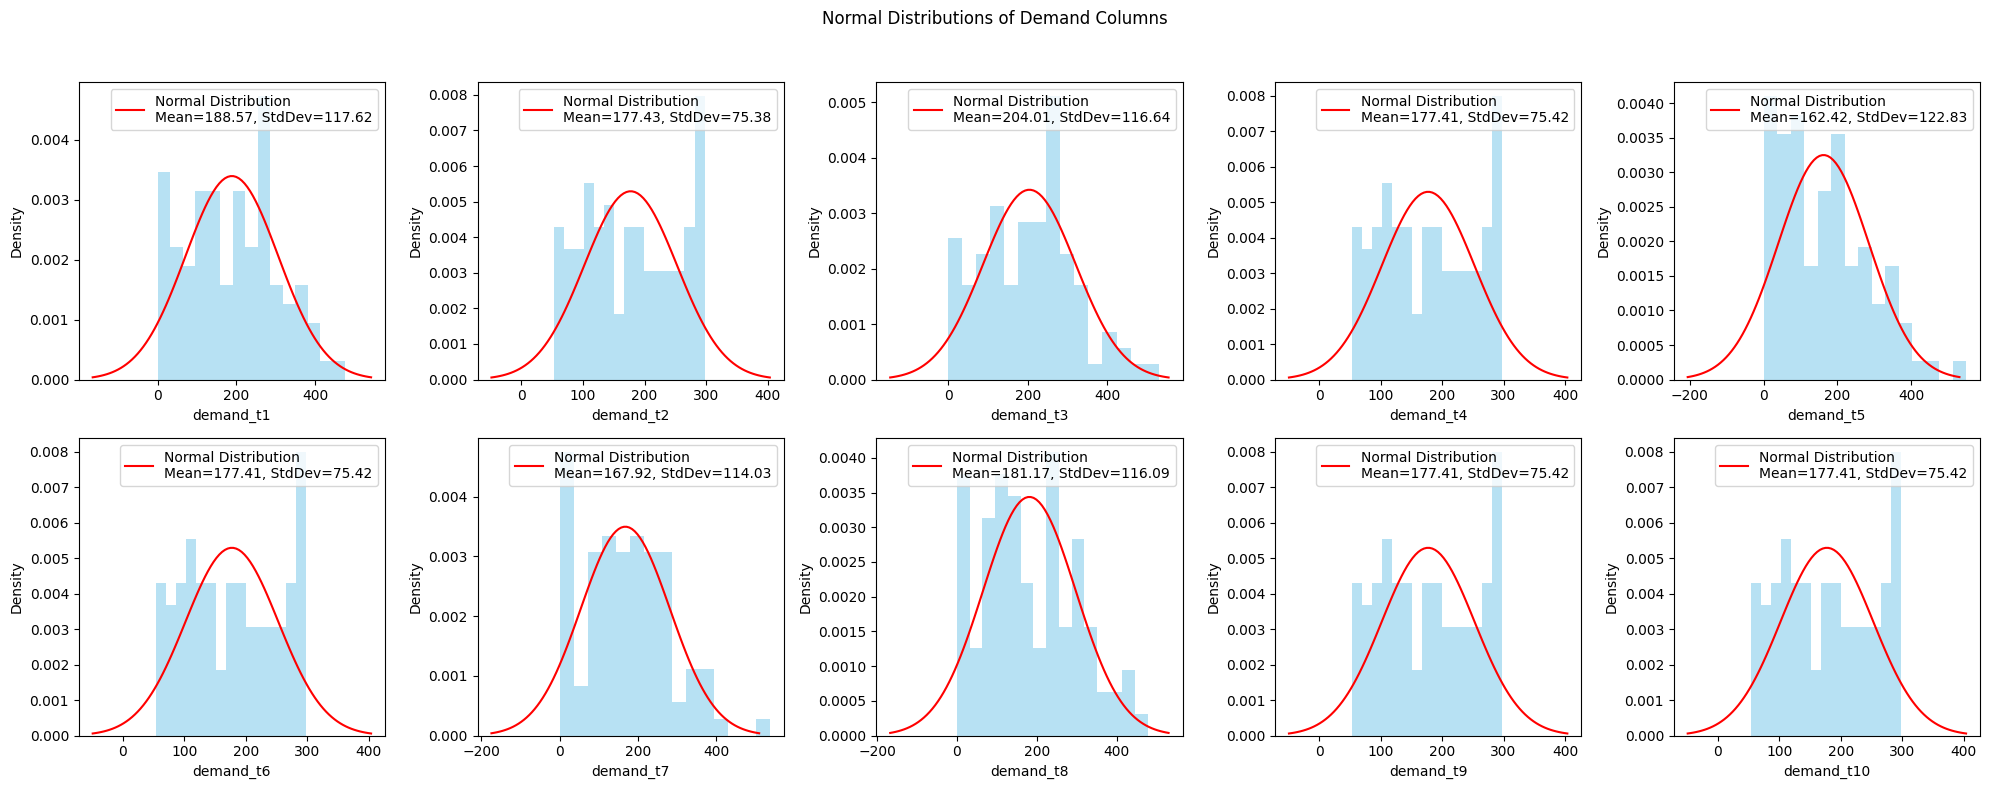

In [243]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [244]:
demand_df.cov()

demand_t1    demand_t2     demand_t3    demand_t4  \
demand_t1   13974.189072  5606.106059   9772.628981  5608.657755   
demand_t2    5606.106059  5739.834562   5241.796260  5742.725982   
demand_t3    9772.628981  5241.796260  13742.718874  5242.985481   
demand_t4    5608.657755  5742.725982   5242.985481  5745.661706   
demand_t5    2771.508136  6328.264035   2632.810554  6330.874600   
demand_t6    5608.657972  5742.726202   5242.985806  5745.661925   
demand_t7    3799.699775  5369.005761   -242.524951  5372.117555   
demand_t8    3059.696709  5849.019272   5589.176572  5850.755654   
demand_t9    5608.657755  5742.725983   5242.985483  5745.661707   
demand_t10   5608.657757  5742.725984   5242.985484  5745.661708   

               demand_t5    demand_t6     demand_t7     demand_t8  \
demand_t1    2771.508136  5608.657972   3799.699775   3059.696709   
demand_t2    6328.264035  5742.726202   5369.005761   5849.019272   
demand_t3    2632.810554  5242.985806   -242.524951   5589.176572   
demand_t4    6330.874600  5745.661925   5372.117555   5850.755654   
demand_t5   15239.700941  6330.874787   7777.350923   8713.737562   
demand_t6    6330.874787  5745.662144   5372.117650   5850.755964   
demand_t7    7777.350923  5372.117650  13133.900591   6489.731373   
demand_t8    8713.737562  5850.755964   6489.731373  13612.029108   
demand_t9    6330.874607  5745.661926   5372.117557   5850.755666   
demand_t10   6330.874607  5745.661926   5372.117558   5850.755667   

              demand_t9   demand_t10  
demand_t1   5608.657755  5608.657757  
demand_t2   5742.725983  5742.725984  
demand_t3   5242.985483  5242.985484  
demand_t4   5745.661707  5745.661708  
demand_t5   6330.874607  6330.874607  
demand_t6   5745.661926  5745.661926  
demand_t7   5372.117557  5372.117558  
demand_t8   5850.755666  5850.755667  
demand_t9   5745.661708  5745.661709  
demand_t10  5745.661709  5745.661709

In [245]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1    demand_t2    demand_t3    demand_t4    demand_t5  \
demand_t1   3974.189072  5603.345076  4214.793597  5608.657755  6649.245065   
demand_t2   5603.345076  5739.764504  5236.763874  5742.725982  6332.425760   
demand_t3   4214.793597  5236.763874  3742.721122  5242.985481  6917.726707   
demand_t4   5608.657755  5742.725982  5242.985481  5745.661706  6330.874600   
demand_t5   6649.245065  6332.425760  6917.726707  6330.874600  5239.700941   
demand_t6   5608.658039  5742.726202  5242.985904  5745.661925  6330.874634   
demand_t7   4790.427796  5371.863064  5272.906497  5372.117555  4774.247517   
demand_t8   5819.112072  5848.456317  5483.551937  5850.755654  5773.563324   
demand_t9   5608.657758  5742.725983  5242.985485  5745.661707  6330.874607   
demand_t10  5608.657757  5742.725984  5242.985484  5745.661708  6330.874607   

              demand_t6    demand_t7    demand_t8    demand_t9   demand_t10  
demand_t1   5608.658039  4790.427796  5819.112072  5608.657758  5608.657757  
demand_t2   5742.726202  5371.863064  5848.456317  5742.725983  5742.725984  
demand_t3   5242.985904  5272.906497  5483.551937  5242.985485  5242.985484  
demand_t4   5745.661925  5372.117555  5850.755654  5745.661707  5745.661708  
demand_t5   6330.874634  4774.247517  5773.563324  6330.874607  6330.874607  
demand_t6   5745.662144  5372.117379  5850.755749  5745.661926  5745.661926  
demand_t7   5372.117379  3133.900591  6100.320598  5372.117558  5372.117558  
demand_t8   5850.755749  6100.320598  3612.183070  5850.755667  5850.755667  
demand_t9   5745.661926  5372.117558  5850.755667  5745.661708  5745.661709  
demand_t10  5745.661926  5372.117558  5850.755667  5745.661709  5745.661709

### Validate the corr matrix of damand_df is close to original setting


In [246]:
demand_df

demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
1   225.614664  224.085871  130.126631  224.085872  198.718647  224.085872   
2   341.013174  144.442777  231.753697  144.437960    0.000000  144.437960   
3   100.202696   94.972576   76.489864   94.900919    0.000000   94.900919   
4   208.492985   56.606974  269.573883   56.169682  160.039948   56.169670   
..         ...         ...         ...         ...         ...         ...   
95  109.113900  106.081184  124.957604  106.079257    0.000000  106.079257   
96  113.744958   74.448771   91.014361   74.461121   76.804032   74.461121   
97  401.372421  265.547879  228.542815  265.547880  274.548205  265.547879   
98  279.455060  293.229872  319.356575  293.229872  397.871895  293.229872   
99  319.102244  290.208664  256.446778  290.208665  347.142126  290.208665   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   118.995864   73.267936  127.948970  127.948970  
1   258.873402   85.129200  224.085872  224.085872  
2     0.000000   17.934353  144.437960  144.437960  
3   220.701924  159.692529   94.900919   94.900919  
4     0.000000  137.604927   56.169682   56.169682  
..         ...         ...         ...         ...  
95    0.000000   16.396227  106.079257  106.079257  
96   77.909944    0.000000   74.461121   74.461121  
97  192.649849  139.333484  265.547879  265.547879  
98  321.351787  289.717083  293.229872  293.229872  
99  355.929601  319.224584  290.208665  290.208665  

[100 rows x 10 columns]

In [247]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.625962   0.705199   0.625930   0.189917   0.625930   
demand_t2    0.625962   1.000000   0.590193   0.999996   0.676623   0.999996   
demand_t3    0.705199   0.590193   1.000000   0.590028   0.181926   0.590028   
demand_t4    0.625930   0.999996   0.590028   1.000000   0.676559   1.000000   
demand_t5    0.189917   0.676623   0.181926   0.676559   1.000000   0.676559   
demand_t6    0.625930   0.999996   0.590028   1.000000   0.676559   1.000000   
demand_t7    0.280472   0.618368  -0.018052   0.618413   0.549726   0.618413   
demand_t8    0.221847   0.661716   0.408649   0.661577   0.604999   0.661577   
demand_t9    0.625930   0.999996   0.590028   1.000000   0.676559   1.000000   
demand_t10   0.625930   0.999996   0.590028   1.000000   0.676559   1.000000   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    0.280472   0.221847   0.625930    0.625930  
demand_t2    0.618368   0.661716   0.999996    0.999996  
demand_t3   -0.018052   0.408649   0.590028    0.590028  
demand_t4    0.618413   0.661577   1.000000    1.000000  
demand_t5    0.549726   0.604999   0.676559    0.676559  
demand_t6    0.618413   0.661577   1.000000    1.000000  
demand_t7    1.000000   0.485365   0.618413    0.618413  
demand_t8    0.485365   1.000000   0.661577    0.661577  
demand_t9    0.618413   0.661577   1.000000    1.000000  
demand_t10   0.618413   0.661577   1.000000    1.000000

In [248]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [249]:
def demand_data_split_data_k_fold(data, train_size, k_fold=2):
    folds = []
    for i in range(k_fold):
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)
        folds.append((train_data, test_data))
    return folds

In [250]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size, k_fold=k_fold)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (50, 10), Test size: (50, 10)
train.head(): 
    demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    0.000000   84.265399  200.254194   84.225068    0.000000   84.225068   
1   97.753348  123.036529   42.387355  123.036882   89.533482  123.036882   
2   42.534007  127.943454    0.000000  127.948970  366.862468  127.948970   
3   17.858570  101.868518   44.472622  101.867519  127.158269  101.867519   
4  396.394546  286.842647  281.187400  286.842647  365.230241  286.842648   

    demand_t7   demand_t8   demand_t9  demand_t10  
0    0.000000  172.118372   84.225068   84.225068  
1  207.532299  151.356021  123.036882  123.036882  
2  118.995864   73.267936  127.948970  127.948970  
3  214.460522  232.339037  101.867519  101.867519  
4  328.706031  188.175296  286.842648  286.842648  

Fold 2:
Train size: (50, 10), Test size: (50, 10)
train.head(): 
    demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0    9.657795   8

In [251]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [252]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [253]:
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

demand_df_train_2 = demand_folds[1][0]
Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 1922.6900013505615
std of sum: 745.789149731619
95.0 percentile of sum: 3149.4039892276696
Q_star: 3149.4039892276696

mean of sum: 1693.0148895622435
std of sum: 764.3211911581172
95.0 percentile of sum: 2950.211372994542
Q_star: 2950.211372994542



## Data3: Qk hat df


### Functions


In [254]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [255]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [256]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [257]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [258]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [259]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [260]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [261]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

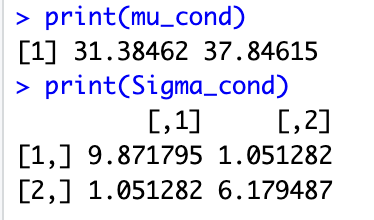
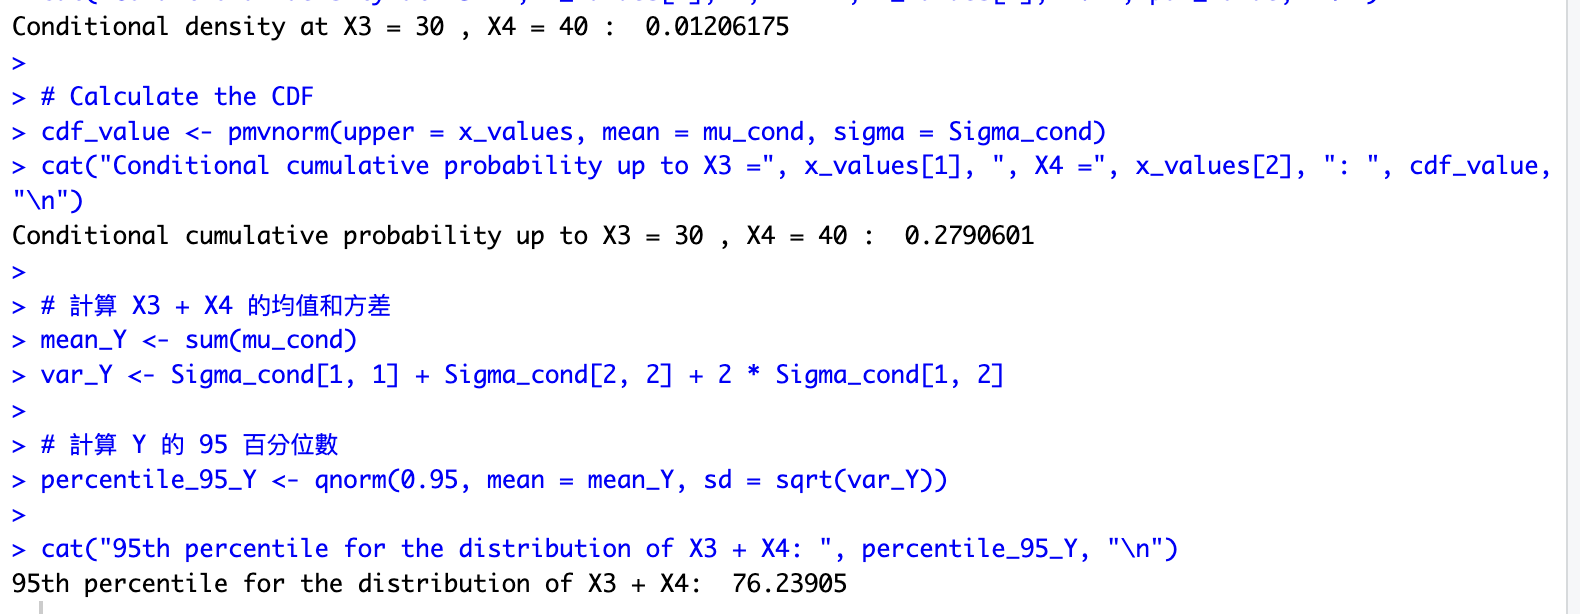


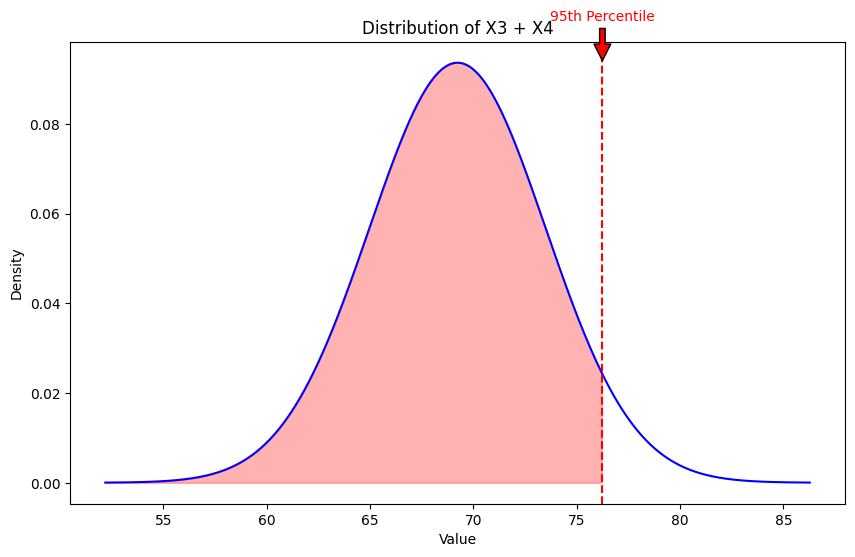

In [262]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


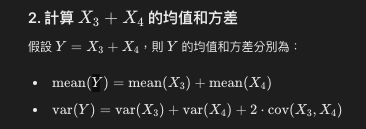


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [263]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.011044263785324
模擬計算的Y的方差: 2.971568550026781


### Calculate Qk hat for 2~T-1 of demand_df_train


In [264]:
demand_df_train = demand_folds[0][0]

In [265]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [266]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615

In [267]:
Qk_hat_df

Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0   2091.512884  1500.117103  1454.669200  1452.338655  1644.324688   
1   2896.177252  2515.849742  2467.898819  2468.338020  2349.757726   
2   3403.369381  1851.784828  1830.255992  1827.765727  1685.351951   
3   2344.974609  1231.777306  1208.438757  1208.540324  1034.265410   
4   2820.925143   946.882987   980.677202   997.240995  1188.565118   
..          ...          ...          ...          ...          ...   
95  2384.140560  1341.008109  1332.840669  1329.133183  1150.271054   
96  2404.494691  1049.894125  1032.286835  1027.185742  1005.164392   
97  3668.656476  3018.177565  2965.025287  2966.484261  2952.684281   
98  3132.813108  3194.661878  3198.167619  3199.036283  3266.055703   
99  3307.067870  3192.893550  3164.245061  3165.857541  3171.889158   

      Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0   1641.969056  1435.318759  1241.604866  
1   2347.528938  2239.152389  2018.743777  
2   1682.581302  1436.817427  1312.688115  
3   1030.113799  1095.323345  1032.060616  
4   1185.480420  1136.048182  1057.539530  
..          ...          ...          ...  
95  1148.636159   939.435638   781.412790  
96  1002.759319   915.343626   731.765264  
97  2949.900812  2711.645370  2564.098163  
98  3263.035002  3257.789202  3073.016844  
99  3169.630162  3148.839121  3048.731160  

[100 rows x 8 columns]

### Plot the distribuction


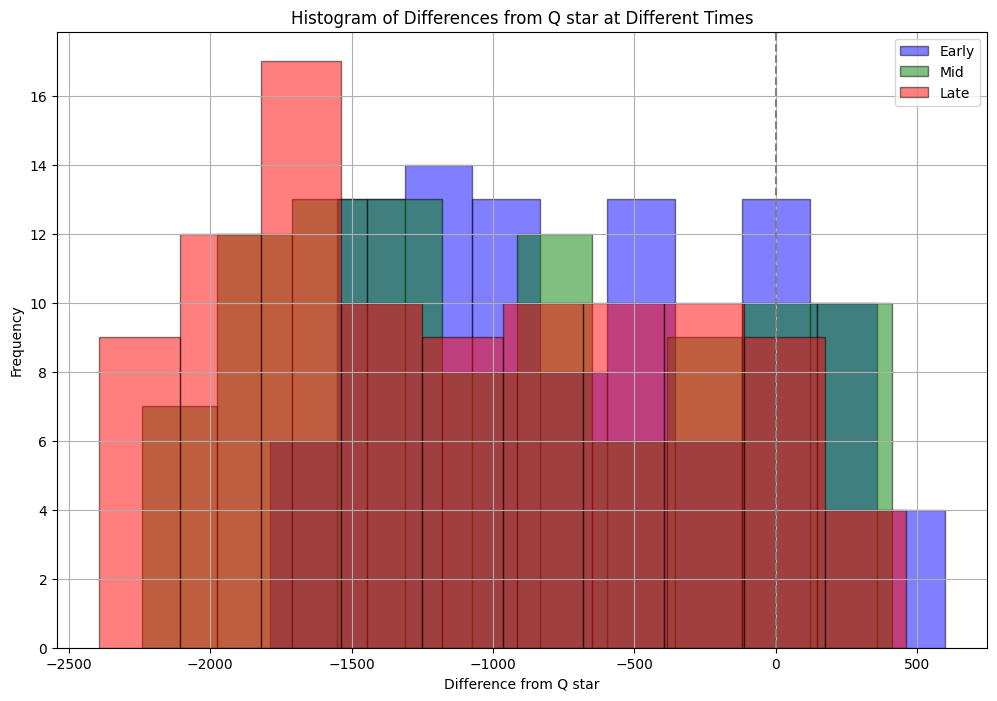

Q_star is: 2950.211372994542
Early bias: -669.122837523615
Mid bias: -942.660266302619
Late bias: -1098.6016272465984


In [268]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

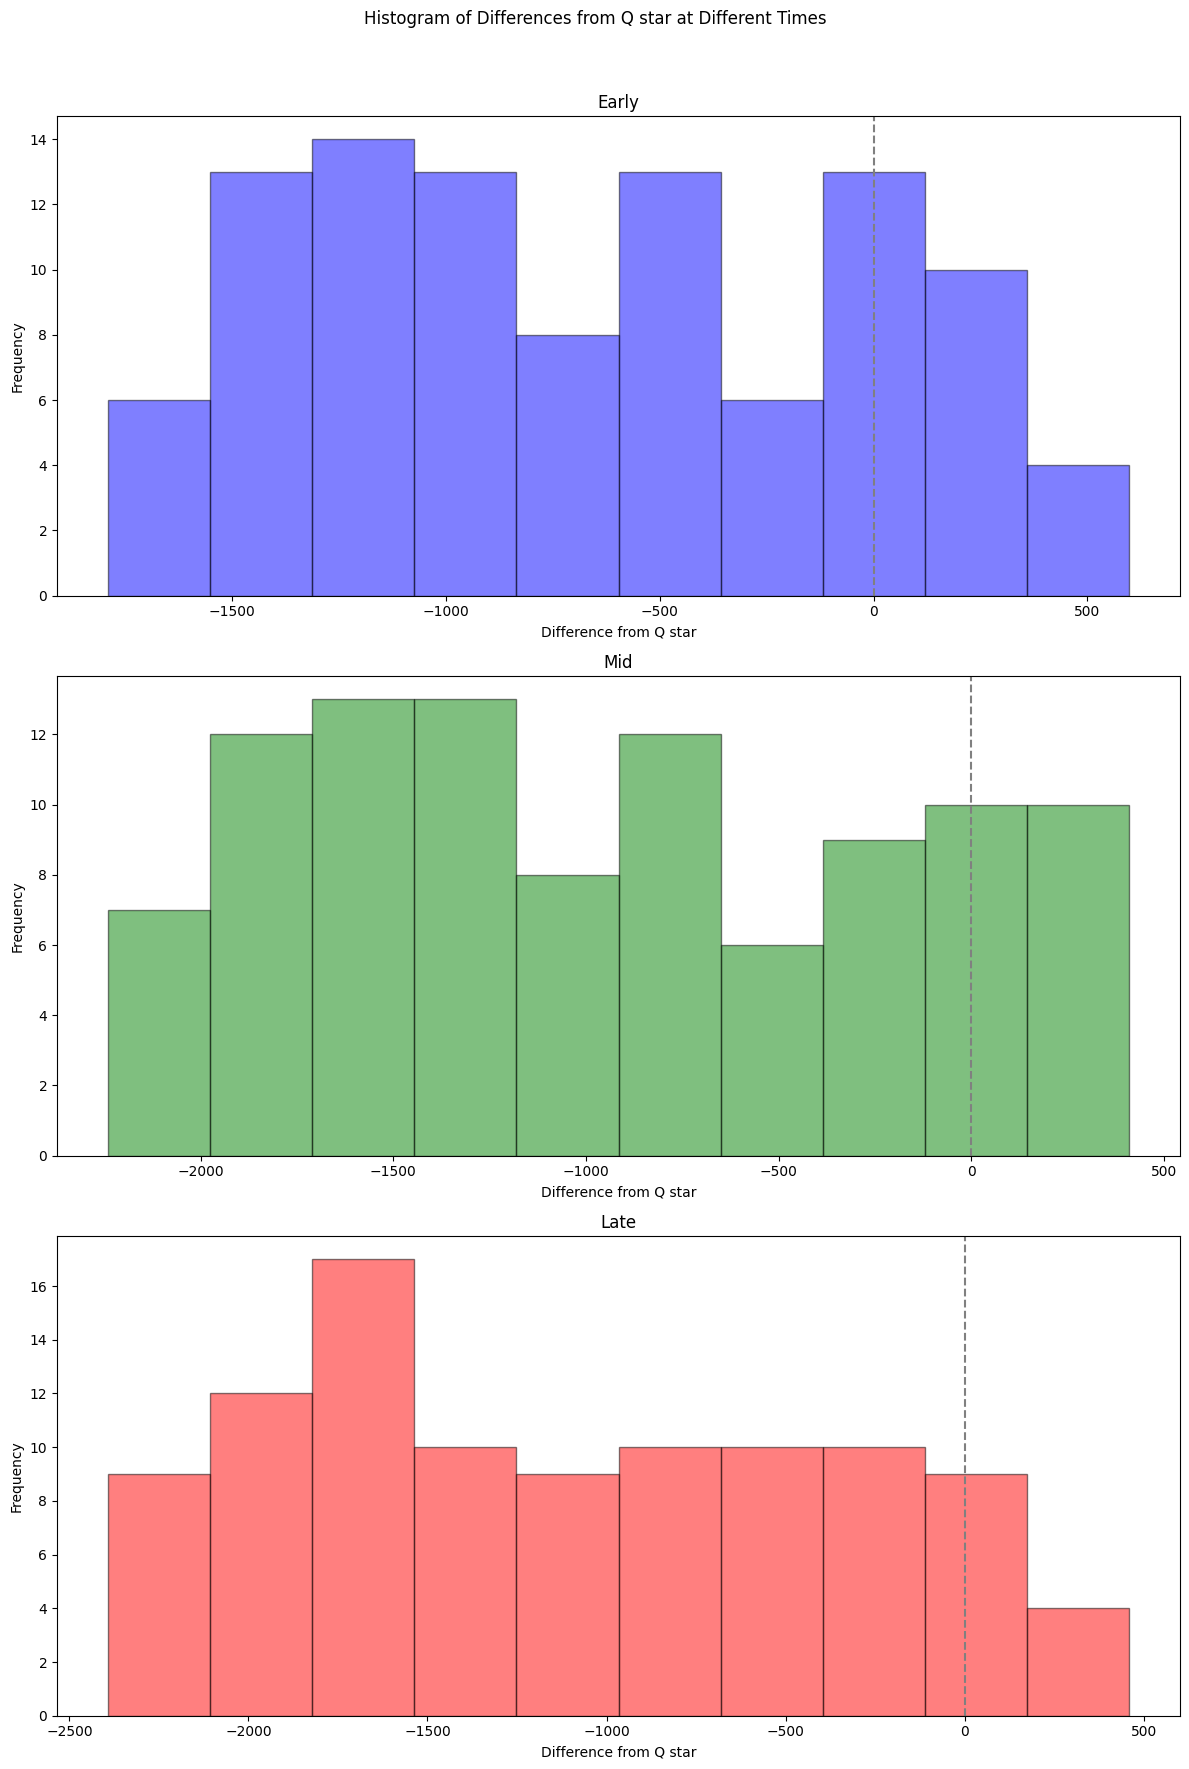

In [269]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## Validation

In [270]:
import gurobipy as gp
from gurobipy import GRB

# 初始化模型
# model = gp.Model("Test_r_R_relationship")
model = gp.Model(env=env)

# 設定參數
K = 4  # 候選數量
i = 0  # 單個 i 的例子

# 定義變數
r_vars = model.addVars(K, lb=0.0, ub=1.0, name="r_vars")  # r_{i,k}
R_vars = model.addVars(K, vtype=GRB.BINARY, name="R_vars")  # R_{i,k}
max_r_helper = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")  # 最大值輔助變數

# 假設 exp_tau_vars 是已知的輸入數值
exp_tau_vars = [0.1, 0.3, 0.5, 0.2]  # 例子數值

# 限制式 1: 定義 r_vars 與 exp_tau_vars 的關係
for k in range(K):
    model.addConstr(
        r_vars[k] * sum(exp_tau_vars) == exp_tau_vars[k],
        name=f"softmax_relation_{k}",
    )

# 限制式 2: 確保 r_vars 的加總為 1
model.addConstr(gp.quicksum(r_vars[k] for k in range(K)) == 1, name="sum_r_constraint")

# 限制式 3: 找出 r_vars 中的最大值
model.addGenConstrMax(
    max_r_helper, [r_vars[k] for k in range(K)], name="max_r_constraint"
)

# 限制式 4: 確保 R_vars 對應到最大值
for k in range(K):
    model.addGenConstrIndicator(
        R_vars[k], 1, r_vars[k] == max_r_helper, name=f"indicator_R_{k}"
    )

# 限制式 5: 確保僅有一個 R_vars[k] 為 1
model.addConstr(
    gp.quicksum(R_vars[k] for k in range(K)) == 1, name="unique_R_constraint"
)

# 設定目標函數（範例：最大化 max_r_helper）
model.setObjective(max_r_helper, GRB.MAXIMIZE)

# 求解模型
model.optimize()

# 輸出結果
if model.Status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(f"max_r_helper: {max_r_helper.X}")
    print("r_vars:")
    for k in range(K):
        print(f"  r_vars[{k}]: {r_vars[k].X}")
    print("R_vars:")
    for k in range(K):
        print(f"  R_vars[{k}]: {R_vars[k].X}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 6 rows, 9 columns and 12 nonzeros
Model fingerprint: 0x2fc3cf89
Model has 5 general constraints
Variable types: 5 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 6 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0.454545 
No other solutions better than 0.454545

Optimal solution found (tolerance 1.00e-04)
Best objective 4.5454

## S0 - One-time Procurement


In [271]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [272]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [273]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [274]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [275]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [276]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):
    print(
        f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
    )
    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Decision Variables =======================
        alphas = model.addVars(
            features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        )
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")

        f_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(xvar=f_vars[i], yvar=F_vars[i])

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # Calculate first period sales and lost sales
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"min_sales_constr_{i}",
            )

            # Calculate lost sales
            Lost_0_expr = total_demand_before_R - Q0_vars[i]
            Lost_0_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_expr_{i}")
            model.addConstr(Lost_0_var == Lost_0_expr)
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_var, 0], name=f"max_lost_constr_{i}"
            )

            # Calculate inventory left after first period
            left_0 = Q0_vars[i] - Sold_0s[i]

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # Calculate second period sales and lost sales
            total_stock_second_period = Q1_vars[i] + left_0
            total_stock_second_period_var = model.addVar(
                lb=0, name=f"total_stock_second_period_{i}"
            )
            model.addConstr(total_stock_second_period_var == total_stock_second_period)

            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, total_stock_second_period_var],
                name=f"min_sales2_constr_{i}",
            )

            # Calculate second period lost sales
            Lost_1_expr = total_demand_after_R - total_stock_second_period_var
            Lost_1_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_expr_{i}")
            model.addConstr(Lost_1_var == Lost_1_expr)

            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_var, 0], name=f"max_lost2_constr_{i}"
            )

            model.addConstr(Left_1s[i] == total_stock_second_period_var - Sold_1s[i])

            # # Calculate holding costs directly in profit equation
            # holding_cost_1 = (
            #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
            # )
            # holding_cost_2 = (
            #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
            # )

            # Calculate profit
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
                    - (cost - salvage_value) * Left_1s[i]  # Salvage cost
                    # - holding_cost * (holding_cost_1 + holding_cost_2)  # Holding cost
                )
            )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s2_model_debug.lp")
        model.write("s2_model.mps")

        # Solve model
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
                print(f"Model status: {model.status}")

                # Collect results
                alpha_values = np.array([alpha.X for alpha in alphas.values()])

                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                }

                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left1 = Left_1s[i].X

                    # Record results
                    results["losses"].append(lost0 + lost1)
                    results["lefts"].append(left1)
                    results["operation_profits"].append(
                        (price - cost) * (sold0 + sold1)
                    )
                    results["profits"].append(profits_vars[i].X)
                    results["Q0s"].append(Q0_vars[i].X)
                    results["Q1s"].append(Q1_vars[i].X)
                    results["Fs"].append(F_vars[i].X)

                    print(f"\nObservation {i+1}:")
                    print(f"Reorder day: {assigned_R}")
                    print(f"Profit: {profits_vars[i].X:.2f}")

                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    alpha_values,
                    results["Fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [277]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")
            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [278]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [279]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
                tau_values,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [280]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [281]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [282]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )
        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            # lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項

                # 定義指數變數
                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{p}")
                neg_tau_var = model.addVar(
                    lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(lb=0, name=f"sum_exp_tau_vars_{i}")
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            eps = 1e-10
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] >= max_r_helpers - eps
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            # model.addConstr(
            #     assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
            #     name=f"Calc_assigned_R_{i}",
            # )

            # # 計算 Holding_Cost_0
            # model.addConstr(
            #     Holding_Cost_0s[i]
            #     == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
            #     name=f"Constr_Holding_Cost_0_{i}",
            # )

            # # 計算 Holding_Cost_1
            # model.addConstr(
            #     Holding_Cost_1s[i]
            #     == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
            #     name=f"Constr_Holding_Cost_1_{i}",
            # )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * Left_1s[i]  # left cost
            #         # - holding_cost
            #         # * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s6_model_debug.lp")
        model.write("s6_model.mps")

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [283]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [284]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [285]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S4 - Beta with softmax


In [286]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # # 设置初始值
        # initial_values = [
        #     [0.5] * (features_num + 1) for _ in range(K)
        # ]  # 这是一个示例，您可以根据需要设置不同的初始值
        # for k in range(K):
        #     for j in range(features_num + 1):
        #         betas[k, j].Start = initial_values[k][j]

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):
                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{k}")
                # neg_tau_var = model.addVar(
                #     lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{k}"
                # )

                # model.addConstr(
                #     neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                # )
                # model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            model.addConstr(
                r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                name=f"softmax_{i}_{k}",
            )
            model.addConstr(
                gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
                name=f"sum_r_{i}",
            )
            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            # 確保 R_vars 的邏輯行為
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            # model.addConstr(
            #     assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
            #     name=f"Calc_assigned_R_{i}",
            # )

            # # 計算 Holding_Cost_0
            # model.addConstr(
            #     Holding_Cost_0s[i]
            #     == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
            #     name=f"Constr_Holding_Cost_0_{i}",
            # )

            # # 計算 Holding_Cost_1
            # model.addConstr(
            #     Holding_Cost_1s[i]
            #     == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
            #     name=f"Constr_Holding_Cost_1_{i}",
            # )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * Left_1s[i]  # left cost
            #         # - holding_cost
            #         # * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                # print("Beta values:")
                # for key, beta in betas.items():
                #     print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                # print(f"------------")
                # print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        # )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [287]:
def fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [288]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [289]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [290]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [291]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [292]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [293]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [294]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [295]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [296]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202502040026

In [297]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.5


In [298]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [299]:
training_df.shape

(50, 4)

In [300]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 1922.6900013505615
std of sum: 745.789149731619
50.0 percentile of sum: 1922.6900013505615
Q_star: 1922.6900013505615


In [301]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615

Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0   1071.258315   788.656188   851.669619   850.699910   798.594418   
1   1503.334819  1227.205848  1188.670859  1186.335795  1091.069918   
2   1259.261545  1229.896152  1184.543843  1182.449662  1385.759635   
3   1150.194419   967.044478   953.223508   951.448947   936.571411   
4   2823.349409  2990.698603  2948.051850  2947.358074  3014.285166   
5   1234.215820  1327.846525  1322.689941  1321.752453  1267.975264   
6   1382.254539  1028.545905   982.324285   983.868227  1225.929821   
7   1366.220964  1512.491683  1568.061304  1568.954087  1482.791933   
8   2608.850076  2604.064465  2652.094161  2653.391346  2666.582226   
9   2463.208350  2501.903801  2501.810585  2501.778238  2485.866544   
10  1879.027823  2924.109316  2922.166492  2923.554793  3154.194094   
11  1884.040847  1110.422481  1083.401981  1080.656271  1019.852662   
12  1591.374317  1218.466138  1267.458416  1267.313025  1275.163411   
13  1677.858620  1940.735738  1950.109679  1950.199435  2068.663199   
14  2725.233644  2802.684224  2820.081770  2820.782447  2920.839498   
15  2004.138474   980.859282  1068.981652  1065.012267  1130.912339   
16  1731.491335  1795.444179  1841.265980  1842.011052  1763.751776   
17  1525.146463  1359.683066  1350.766789  1349.518543  1495.996364   
18  2109.661968   696.561441   661.781050   668.629122   638.100841   
19  1870.562699  2103.234322  2126.175456  2126.713797  2032.944660   
20  2630.606809  2684.979233  2679.404009  2679.370251  2480.888151   
21  1576.790983  2264.710044  2286.323848  2287.470485  2074.221019   
22  2236.186846  1814.265391  1781.861845  1779.929233  1756.354048   
23  2845.351957  2795.669404  2733.772557  2732.164911  2705.601983   
24  2306.468857  2958.990931  2959.079286  2960.090002  3057.362976   
25  2014.983855  1769.490324  1734.736356  1732.913813  1608.837672   
26  1924.946181  2088.349448  2080.880110  2080.499774  2051.516346   
27  1993.705063  1825.723839  1783.812039  1781.930694  1939.907512   
28  1478.740215  1330.325347  1373.340343  1373.396062  1358.603714   
29  2538.972843  2594.410889  2594.668630  2594.730708  2602.199445   
30  2120.633626  2879.135203  2853.452994  2853.830346  2808.210337   
31  1369.559368  1603.895552  1612.330838  1612.126682  1588.911829   
32  2231.354775  2656.191518  2632.467233  2632.351572  2446.877232   
33  2027.599571  1958.062844  1987.809240  1988.077865  2028.667681   
34  1660.533669  1943.063728  1928.817432  1928.289433  1816.952888   
35  1764.119407  2424.625251  2455.085146  2456.553240  2552.627296   
36  3177.201608  3087.266644  3133.768937  3135.266670  3172.287124   
37  1723.434827  2132.352071  2153.916795  2154.643530  2297.397272   
38  1184.764225  1650.199839  1650.607474  1650.483612  1710.626985   
39  2986.006959  3089.802398  3123.941956  3125.331236  3199.151520   
40  1461.731833  1654.741356  1621.050754  1619.685293  1588.334724   
41  1279.608338  1379.195716  1359.748656  1358.499534  1362.606799   
42  1675.442736  2613.282871  2596.373197  2597.010173  2525.155583   
43  1320.931090   538.191856   507.415134   519.606705   480.562626   
44  2628.709075  2837.892792  2798.567914  2797.905245  2764.292803   
45  1574.018835   785.833041   776.443342   774.309758   793.189790   
46  2307.296928  2056.522004  2085.595456  2085.703799  2114.944731   
47  1770.837088  2156.701261  2143.826941  2143.607885  1955.276730   
48  2268.342413  1108.777447  1115.507601  1111.658293  1086.101558   
49  2194.935641  2341.297984  2344.564786  2344.635777  2350.986516   

      Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0    797.902340   797.348009   792.730605  
1   1091.883550  1148.633318  1202.893981  
2   1385.972873  1285.081597  1241.086493  
3    936.876210  1058.684001  1144.983680  
4   3018.190853  3051.589000  2995.113732  
5   1266.937381  1233.295117  1191.571391  
6   1219.036789  1368.427481  1293.055777  
7   1480.819167  1388.178715  13

## Training


### S0 - One-time procurement strategy


In [302]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/50 with initial inventory Q_star=1922.6900013505615
--------------------------------------------------
Day 1
Demand      : 0.0
Sales       : 0.0
Loss        : 0
Left        : 1922.6900013505615
Inventory   : 1922.6900013505615
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 84.26539854020012
Sales       : 84.26539854020012
Loss        : 0
Left        : 1838.4246028103614
Inventory   : 1838.4246028103614
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 200.2541936616139
Sales       : 200.2541936616139
Loss        : 0
Left        : 1638.1704091487475
Inventory   : 1638.1704091487475
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 84.22506790469883
Sales       : 84.22506790469883
Loss        : 0
Left        : 1553.9453412440487
Inventory   : 1553.94534124

In [303]:
baseline_stimulation_df

losses        lefts  operation_profits        profits
0      0.000000  1129.151766      396769.117862 -167806.764951
1      0.000000   718.943442      601873.279817  242401.558958
2      0.000000   681.290391      620699.805109  280054.609543
3      0.000000   777.062389      572813.806363  184282.612052
4   1071.216749     0.000000      961345.000675  425736.625933
5      0.000000   730.675824      596007.088583  230669.176490
6      0.000000   628.460817      647114.591951  332884.183227
7      0.000000   551.180856      685754.572894  410164.145113
8    721.931248     0.000000      961345.000675  600379.376878
9    806.746944     0.000000      961345.000675  557971.528559
10  1448.880134     0.000000      961345.000675  236904.933497
11     0.000000   762.350542      580169.729767  198994.458859
12     0.000000   713.080180      604804.910431  248264.820186
13   154.373840     0.000000      961345.000675  884158.080882
14   991.704227     0.000000      961345.000675  465492.887314
15     0.000000   772.944283      574872.858953  188400.717231
16     0.000000   153.488461      884600.769987  807856.539299
17     0.000000   635.130608      643779.696883  326214.393090
18     0.000000  1324.959143      298865.429144 -363614.142387
19     0.000000     5.873743      958408.129339  955471.258003
20   573.190305     0.000000      961345.000675  674749.848318
21     0.000000    41.565786      940562.107541  919779.214406
22     0.000000   357.664424      782512.788617  603680.576560
23   641.496171     0.000000      961345.000675  640596.915325
24  1151.211761     0.000000      961345.000675  385739.120114
25     0.000000    37.459896      942615.052875  923885.105075
26     0.000000    32.803994      944943.003836  928541.006997
27     0.000000   174.834803      873927.598936  786510.197196
28     0.000000   569.302006      676693.997734  392042.994793
29   752.574774     0.000000      961345.000675  585057.613675
30   943.586980     0.000000      961345.000675  489551.510715
31     0.000000   372.395961      775147.019942  588949.039208
32   435.013156     0.000000      961345.000675  743838.422728
33   136.078317     0.000000      961345.000675  893305.842109
34    71.334259     0.000000      961345.000675  925677.871242
35   626.862895     0.000000      961345.000675  647913.553082
36  1245.387285     0.000000      961345.000675  338651.358203
37   311.976995     0.000000      961345.000675  805356.503092
38     0.000000   112.497453      905096.274094  848847.547512
39  1251.234256     0.000000      961345.000675  335727.872664
40     0.000000   183.681498      869504.251919  777663.503162
41     0.000000   636.313003      643188.499171  325031.997666
42   610.702490     0.000000      961345.000675  655993.755511
43     0.000000  1423.419733      249635.134103 -462074.732470
44   740.002788     0.000000      961345.000675  591343.606470
45     0.000000  1190.923449      365883.275959 -229578.448758
46   456.135865     0.000000      961345.000675  733277.068424
47     0.000000    26.977661      947856.170171  934367.339667
48     0.000000   828.867670      546911.165834  132477.330993
49   431.658343     0.000000      961345.000675  745515.829029

### S1 - Grid for Fixed F & Fixed Rk


In [304]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 1922.6900013505615
期初庫存 Q0: 192.26900013505616
重新估計量 Qk_hat: 1071.2583149602565
訂貨量 Q1 為 878.9893148252004

第一階段：期初庫存 Q0: 192.26900013505616，需求量為 0.0，Sold_0 為 0.0，Left_0 為 192.26900013505616，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 1071.2583149602565，需求量為 793.5382357245975，Sold_1 為 793.5382357245975，Left_1 為 277.720079235659，Lost_1 為 0

統計結果：Sold 為 793.5382357245975, Lost 為 0 Left_Penalty_Cost 為 138860.0396178295，Lost_Penalty_Cost 為 0，Profit 為 257909.07824446924
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 1922.6900013505615
期初庫存 Q0: 192.26900013505616
重新估計量 Qk_hat: 1503.3348194820567
訂貨量 Q1 為 1311.0658193470006

第一階段：期初庫存 Q0: 192.26900013505616，需求量為 97.75334768095311，Sold_0 為 97.75334768095311，Left_0 為 94.51565245410305，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 1405.5814718011036，需求量為 1105.9932119523949，Sold_1 為 1105.9932119523949，Left_1 為 299.58825984870873，Lost_1 為 0

統計結果：Sold 為 1203.746559633348, Lost 為 0 Left_Penalty_Cost 為 149

R(T)    F                                                 Q0  \
12     3  0.4  [769.0760005402246, 769.0760005402246, 769.076...   
14     3  0.6  [1153.614000810337, 1153.614000810337, 1153.61...   
23     4  0.6  [1153.614000810337, 1153.614000810337, 1153.61...   
13     3  0.5  [961.3450006752807, 961.3450006752807, 961.345...   
11     3  0.3  [576.8070004051685, 576.8070004051685, 576.807...   
..   ...  ...                                                ...   
65     9  0.3  [576.8070004051685, 576.8070004051685, 576.807...   
45     7  0.1  [192.26900013505616, 192.26900013505616, 192.2...   
54     8  0.1  [192.26900013505616, 192.26900013505616, 192.2...   
64     9  0.2  [384.5380002701123, 384.5380002701123, 384.538...   
63     9  0.1  [192.26900013505616, 192.26900013505616, 192.2...   

                                                   Q1  average_profits  \
12  [19.58018769043565, 458.12984763017744, 460.82...     8.651828e+05   
14  [0, 73.591847360065, 76.28215073365027, 0, 183...     8.600588e+05   
23  [0, 35.05685808607723, 30.929842026868073, 0, ...     8.592316e+05   
13  [0, 265.86084749512133, 268.5511508687066, 5.6...     8.580018e+05   
11  [211.84918782549175, 650.3988477652335, 653.08...     8.542480e+05   
..                                                ...              ...   
65  [215.92360432186547, 626.0869810365787, 664.27...    -4.977799e+05   
45  [605.6333396827531, 899.6145502295817, 1193.70...    -5.105309e+05   
54  [605.0790089540226, 956.3643182385267, 1092.81...    -7.635803e+05   
64  [408.1926044569217, 818.3559811716349, 856.548...    -7.771710e+05   
63  [600.4616045919779, 1010.6249813066911, 1048.8...    -1.065574e+06   

    average_losses  average_lefts  average_operation_profits  
12       62.085493      68.153467              930302.254263  
14       51.673268      99.225946              935508.366598  
23       52.197100      99.832657              935246.450645  
13       61.987852      82.710601              930351.074738  
11       71.140585      71.912888              925774.708267  
..             ...            ...                        ...  
65      972.229232     973.791361              475230.384725  
45      981.209538     981.332806              470740.231557  
54     1149.949881    1149.950856              386370.060058  
64     1159.007632    1159.016704              381841.184691  
63     1351.276632    1351.285704              285706.684624  

[72 rows x 8 columns]

In [305]:
stimulation_results_df_1

R(T)    F       profits      losses       lefts      Left0s      Left1s  \
0      3  0.4  3.918871e+05    4.882047    0.000000  684.810602    0.000000   
1      3  0.4  5.901436e+05    0.000000   23.459289  548.286124   23.459289   
2      3  0.4  6.091963e+05   11.503459    0.000000  598.598539    0.000000   
3      3  0.4  3.942307e+05  178.583135    0.000000  649.348913    0.000000   
4      3  0.4  1.493745e+06    3.208148    0.000000   85.838807    0.000000   
5      3  0.4  5.280909e+05    0.000000  135.832348  593.305089  135.832348   
6      3  0.4  3.814313e+05  265.683279    0.000000  594.655130    0.000000   
7      3  0.4  6.152633e+05    0.000000  140.982537  546.171497  140.982537   
8      3  0.4  1.281754e+06   40.556784    0.000000  171.698253    0.000000   
9      3  0.4  1.137185e+06  227.533144    0.000000  212.828753    0.000000   
10     3  0.4  1.238324e+06  447.460819    0.000000  288.740819    0.000000   
11     3  0.4  5.302528e+05   49.916978    0.000000  481.861443    0.000000   
12     3  0.4  6.003768e+05    0.000000    8.856318  530.969691    8.856318   
13     3  0.4  9.022038e+05  136.328103    0.000000  435.719223    0.000000   
14     3  0.4  1.345487e+06  111.710004    0.000000  126.307255    0.000000   
15     3  0.4  4.059864e+05  168.886436    0.000000  470.833301    0.000000   
16     3  0.4  8.714795e+05    0.000000   26.242639  440.154116   26.242639   
17     3  0.4  6.077179e+05    0.000000   72.123672  529.582179   72.123672   
18     3  0.4  2.131929e+05    0.000000  171.345142  479.391364  171.345142   
19     3  0.4  8.651991e+05    0.000000  186.418063  378.372589  186.418063   
20     3  0.4  1.153391e+06    0.000000  189.098927  158.525586  189.098927   
21     3  0.4  7.487692e+05    0.000000  383.585829  421.989918  383.585829   
22     3  0.4  6.578929e+05    0.000000  249.239814  333.507544  249.239814   
23     3  0.4  1.166351e+06    0.000000  231.483232  102.155700  231.483232   
24     3  0.4  1.422040e+06  114.910831    0.000000  196.391068    0.000000   
25     3  0.4  8.268753e+05  115.739781    0.000000  384.159864    0.000000   
26     3  0.4  8.457113e+05    0.000000  198.463441  368.691460  198.463441   
27     3  0.4  8.349933e+05    0.000000   77.868641  382.551365   77.868641   
28     3  0.4  6.536313e+05   23.062648    0.000000  542.345780    0.000000   
29     3  0.4  1.256779e+06   80.853886    0.000000  187.218398    0.000000   
30     3  0.4  1.426709e+06    0.000000   12.858221  243.466544   12.858221   
31     3  0.4  7.483463e+05    0.000000   53.601513  535.694368   53.601513   
32     3  0.4  1.029607e+06    0.000000  298.488361  244.378924  298.488361   
33     3  0.4  9.286787e+05  100.705475    0.000000  361.357238    0.000000   
34     3  0.4  9.460516e+05   50.960533    0.000000  439.061754    0.000000   
35     3  0.4  1.149849e+06  124.927645    0.000000  366.034303    0.000000   
36     3  0.4  1.503228e+06   80.810642    0.000000    2.141544    0.000000   
37     3  0.4  1.015019e+06  102.314925    0.000000  405.757495    0.000000   
38     3  0.4  7.451036e+05  159.992710    0.000000  569.048458    0.000000   
39     3  0.4  1.502840e+06   84.121859    0.000000   41.507892    0.000000   
40     3  0.4  7.852371e+05   84.267147    0.000000  511.142319    0.000000   
41     3  0.4  5.967791e+05    0.000000   92.818718  578.397406   92.818718   
42     3  0.4  1.226751e+06    0.000000   79.890379  364.222151   79.890379   
43     3  0.4  1.147323e+05    0.000000  269.805732  659.862174  269.805732   
44     3  0.4  1.243746e+06    0.000000  175.200002  142.549223  175.200002   
45     3  0.4  3.388500e+05    0.000000   54.066490  580.882271   54.066490   
46     3  0.4  8.671091e+05  322.303862    0.000000  292.831048    0.000000   
47     3  0.4  8.173617e+05    0.000000  260.988921  393.323579  260.988921   
48     3  0.4  5.394336e+05    0.000000   14.955115  402.365489   14.955115   
49     3  0.4  1.164124e+06   13.050361    0.000000  2

In [306]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 1922.6900013505615
Maximum Profit: 865182.7744056751


In [307]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
12     3  0.4    865182.774406
14     3  0.6    860058.759578
23     4  0.6    859231.572233

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_med_with_holding_cost_20_100_202502040026.png


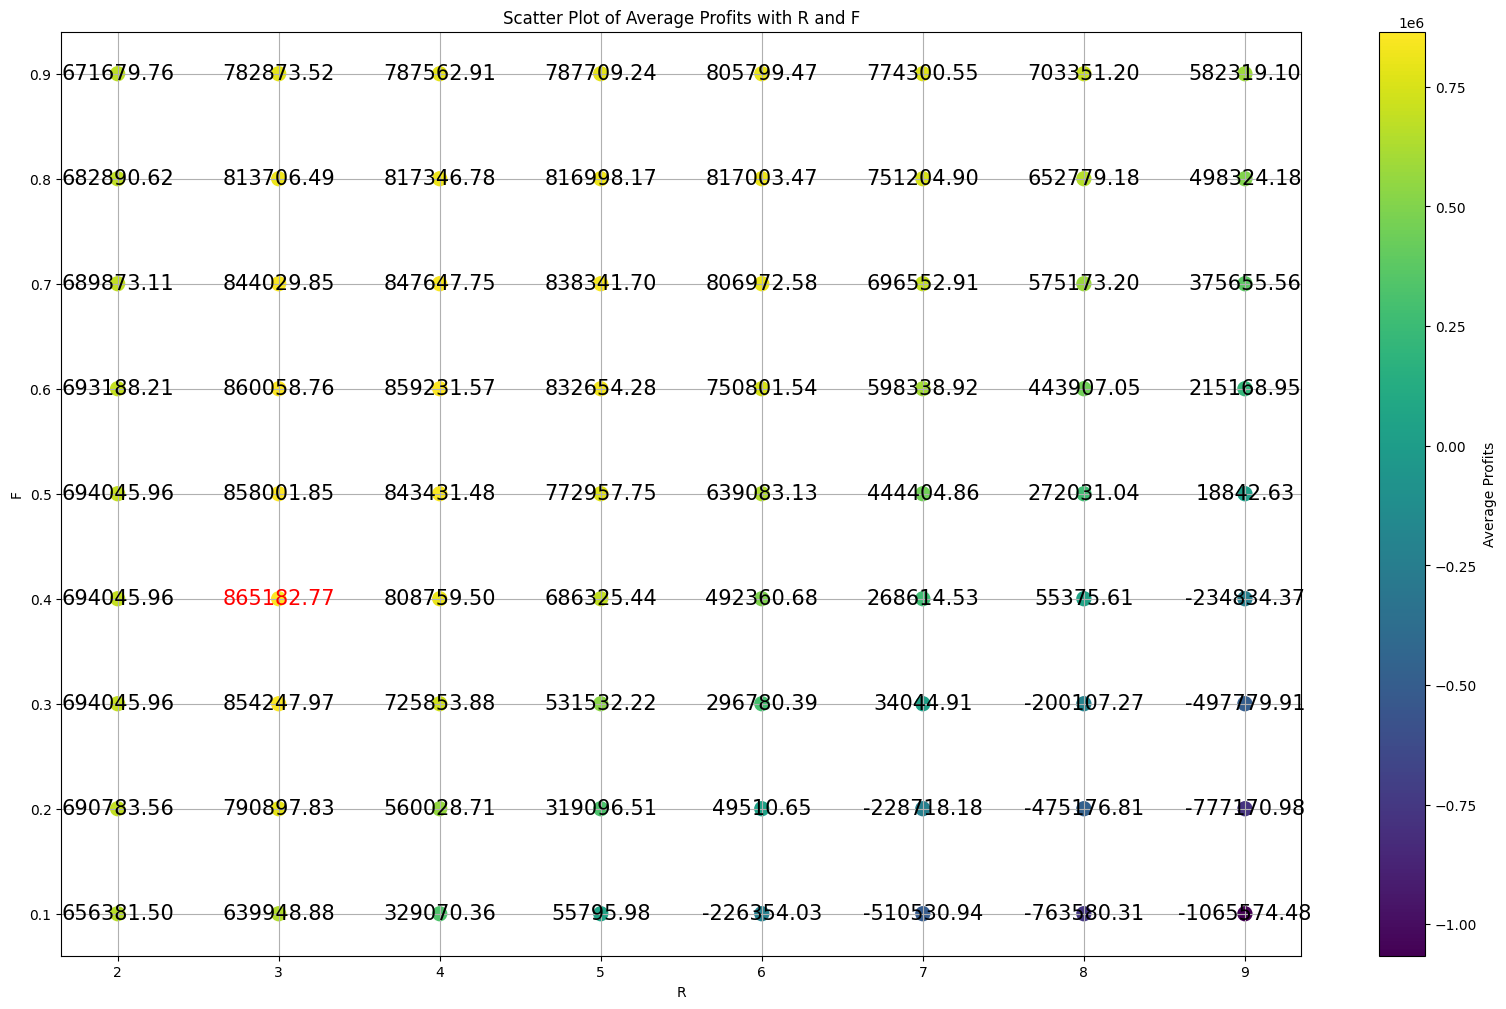

In [308]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_med_with_holding_cost_20_100_202502040026.png


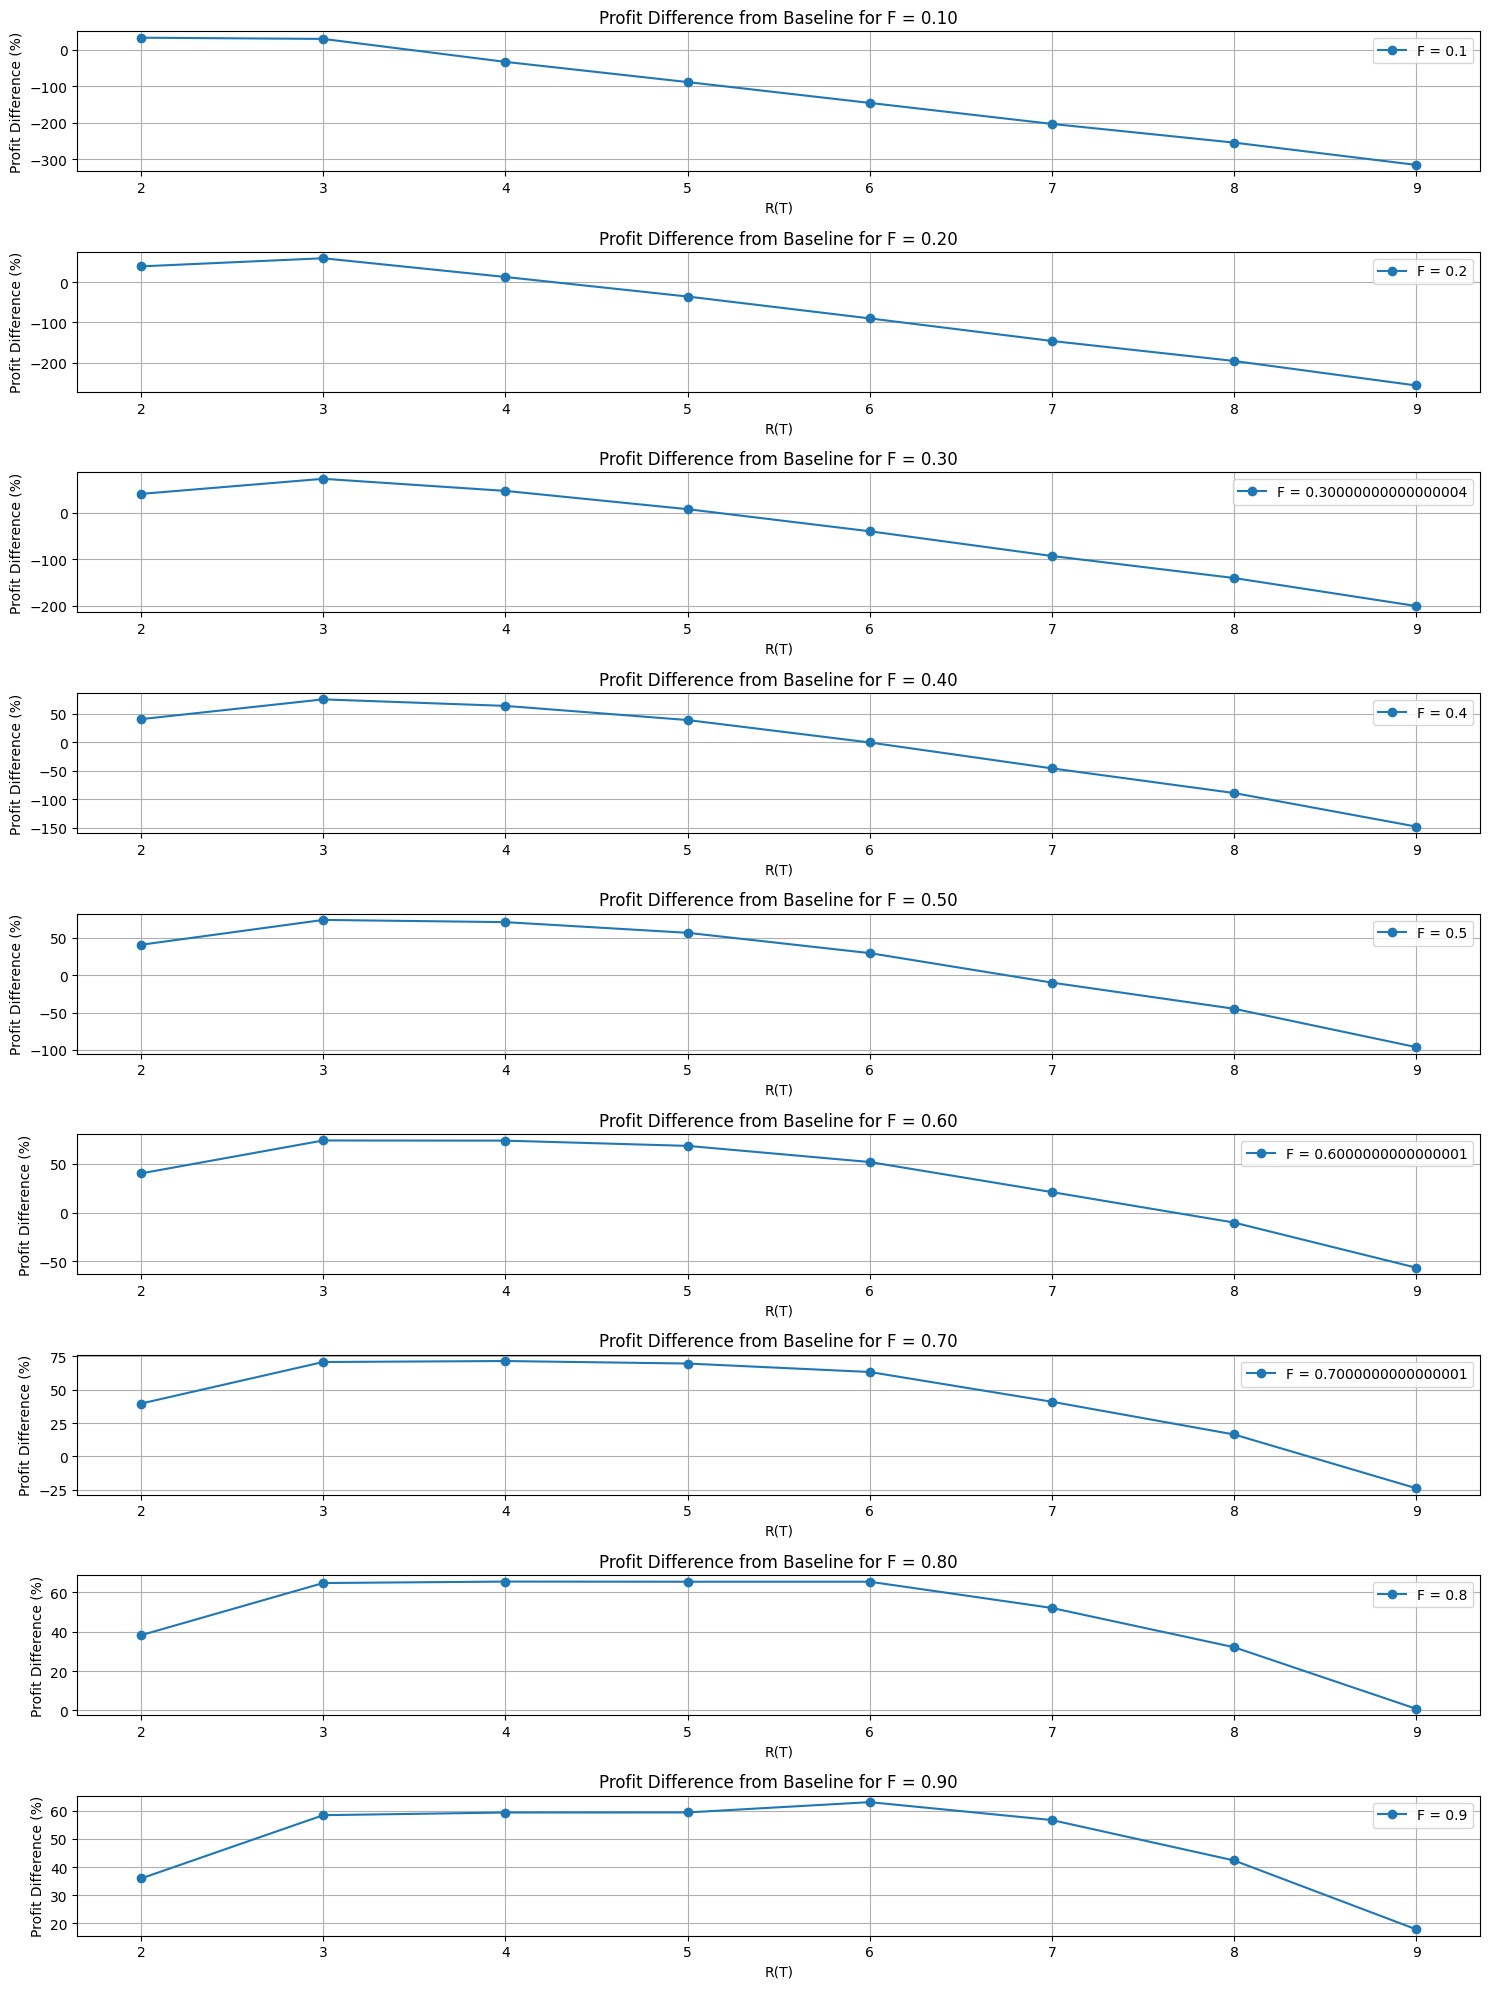

In [309]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S8 - Grid for Fixed F & Fixed Rk


In [310]:
results_df_8, stimulation_results_df_8 = None, None

# results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
#     assigned_Ts=ASSIGNED_TS,
#     assigned_Fs=ASSIGNED_FS,
#     cost=cost,
#     price=price,
#     salvage_value=salvage_value,
#     Qk_hat_df=Qk_hat_df_train,
#     demand_df_train=demand_df_train,
#     Q_star=Q_star,
#     holding_cost=holding_cost,
# )
# results_df_8

In [311]:
stimulation_results_df_8

In [312]:
# # 比較結果
# max_profit = results_df_8["average_profits"].max()

# print("\n============ Below is the comparison results =================")
# print(f"Q_star: {Q_star}")
# print(f"Maximum Profit: {max_profit}")

In [313]:
# # 找出 average_profits 前三名的資料
# top_three_results = results_df_8.head(3)

# # 提取 R (T), F 和 average_profits
# top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
# top_three_info

In [314]:
# # 找到 'average_profits' 的最大值
# max_profit = results_df_8["average_profits"].max()

# # 画出散点图
# plt.figure(figsize=(20, 12))
# sc = plt.scatter(
#     results_df_8["R(T)"],
#     results_df_8["F"],
#     c=results_df_8["average_profits"],
#     cmap="viridis",
#     s=100,
# )
# plt.colorbar(label="Average Profits")
# plt.xlabel("R")
# plt.ylabel("F")
# plt.title("Scatter Plot of Average Profits with R and F")
# plt.grid(True)

# # 在每个数据点上标注数值
# for i in range(len(results_df_8)):
#     avg_profit = results_df_8["average_profits"].iloc[i]
#     # 判断是否等于 max_profit 的整數部分
#     if int(avg_profit) == int(max_profit):
#         plt.text(
#             results_df_8["R(T)"].iloc[i],
#             results_df_8["F"].iloc[i],
#             f"{avg_profit:.2f}",
#             fontsize=15,
#             ha="center",
#             va="center",
#             color="red",
#         )
#     else:
#         plt.text(
#             results_df_8["R(T)"].iloc[i],
#             results_df_8["F"].iloc[i],
#             f"{avg_profit:.2f}",
#             fontsize=15,
#             ha="center",
#             va="center",
#             color="black",
#         )

# name = "grid_fixed_F_fixed_R_metrics_s8"

# os.makedirs("plots", exist_ok=True)
# save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

# plt.savefig(save_path, format="png", bbox_inches="tight")
# print(f"Plot saved as {save_path}")

# # Show plot
# plt.show()
# plt.close()

In [315]:
# results_df_8["baseline_profit"] = baseline_avg_profits

# # Calculate percentage difference from baseline profit
# results_df_8["profit_diff_percent"] = (
#     (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
# ) * 100

# # Plot subplots for different values of F
# plt.figure(figsize=(15, 20))

# for idx, F in enumerate(ASSIGNED_FS):
#     plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
#     subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
#     plt.plot(
#         subset["R(T)"],
#         subset["profit_diff_percent"],
#         marker="o",
#         linestyle="-",
#         label=f"F = {F}",
#     )
#     plt.xlabel("R(T)")
#     plt.ylabel("Profit Difference (%)")
#     plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
#     plt.grid(True)
#     plt.legend()

# plt.tight_layout()

# name = "grid_fixed_F_fixed_R_trend_s8"

# os.makedirs("plots", exist_ok=True)
# save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

# plt.savefig(save_path, format="png", bbox_inches="tight")
# print(f"Plot saved as {save_path}")

# # Show plot
# plt.show()
# plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [316]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 5000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 500 rows, 705 columns and 1450 nonzeros
Model fingerprint: 0x65ebda96
Model has 300 general constraints
Variable types: 705 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [2e+01, 3e+03]
Presolve added 50 rows and 300 columns
Presolve time: 0.01s
Presolved: 550 rows, 1005 columns, 2856 nonzeros
Presolved model has 50 SOS c

In [317]:
print(f"Feasible R: {results_df_2['R(T)'].unique()}")
results_df_2

Feasible R: [6 7 5 4 3 8 9 2]


R(T)                                                  R  average_profits  \
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...    910397.529078   
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...    900550.384117   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...    887323.058173   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...    887080.955061   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    882169.480130   
6     8  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...    866491.557912   
7     9  [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...    781026.133686   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    743365.899513   

   average_losses  average_lefts  average_operation_profits  \
4       24.437553      53.019836              949126.223945   
5       27.571572      66.446027              947559.183717   
3       43.823447      60.396869              939433.216339   
2       44.133434      60.261224              939278.283883   
1       48.132774      62.085493              937278.613609   
6       59.794758      70.117370              931447.621870   
7      114.282442     132.072851              904203.779895   
0      126.433507     183.091188              898128.247060   

                                        alpha_values  \
4  [-0.5345865479865739, 0.06079981729097808, 2.0...   
5  [-1.0344690695424543, -0.007775123757140284, 3...   
3  [0.0750553408071874, 0.3649349129880647, 1.144...   
2  [0.17294154693141958, 0.3736722189256459, 0.92...   
1  [-0.2693792927165763, -0.19716910424452272, 0....   
6  [-0.2628638255226686, 0.041870411202068886, 1....   
7  [-0.49650093767865455, -0.19704502027738227, 2...   
0  [-0.4021970707143061, -0.6819848385068573, 2.8...   

                                              F_vars  \
4  [0.4153526657815651, 0.6719796711129749, 0.5, ...   
5  [0.287792875448086, 0.7211539181865502, 0.7208...   
3  [0.28779315609842226, 0.5, 0.28779367940104517...   
2  [0.28100542424667646, 0.626074176694005, 0.645...   
1  [0.287792875448086, 0.5056052624312248, 0.6456...   
6  [0.38443069168701266, 0.626074176694005, 0.500...   
7  [0.41272292213887307, 0.49809006941544004, 0.5...   
0  [0.5, 0.5000011384326015, 0.5, 0.5700044002915...   

                                             Q0_vars  \
4  [798.5944175325167, 1292.0085947597554, 961.34...   
5  [553.3364840839624, 1386.5554279320609, 1385.9...   
3  [553.3370236875578, 961.3446046022781, 553.338...   
2  [540.2863195243574, 1203.7465596333482, 1241.3...   
1  [553.3364840839624, 972.1221827067427, 1241.39...   
6  [739.1410471188997, 1203.7465596333482, 961.34...   
7  [793.5382357245975, 957.6727962370736, 985.501...   
0  [961.3443055565184, 961.3471895282609, 961.345...   

                                             Q1_vars  
4  [0.0, 0.0, 424.4140004502192, 0.0, 1096.349252...  
5  [244.56585573384675, 0.0, 0.0, 0.0, 1096.14562...  
3  [297.3628864695116, 224.9911900134567, 629.111...  
2  [311.3832990061535, 0.0, 0.0, 0.0, 2029.482157...  
1  [235.3197041466978, 255.0836654636593, 0.0, 0....  
6  [58.20696197017833, 0.0, 323.73603719019627, 0...  
7  [0.0, 245.2211852046736, 255.58482375336678, 2...  
0  [109.91400940373805, 541.9876299537949, 297.91...

In [318]:
stimulation_results_df_2

R         F       profits      losses       lefts  operation_profits  \
0   4  0.415353  3.942410e+05    0.000000    5.056182       3.967691e+05   
1   4  0.671980  5.577423e+05    0.000000   88.262035       6.018733e+05   
2   4  0.500000  5.485198e+05    0.000000  144.360025       6.206998e+05   
3   4  0.696614  4.759412e+05    0.000000  193.745237       5.728138e+05   
4   4  0.997527  1.486764e+06    0.000000   20.378415       1.496953e+06   
5   4  0.500000  5.580265e+05    0.000000   75.961087       5.960071e+05   
6   4  0.673135  6.471146e+05    0.000000    0.000000       6.471146e+05   
7   4  0.500000  6.301132e+05    0.000000  111.282787       6.857546e+05   
8   4  0.985231  1.311330e+06    0.000000   21.960977       1.322311e+06   
9   4  0.958508  1.121148e+06  243.570402    0.000000       1.242933e+06   
10  4  0.991243  1.468409e+06  217.376042    0.000000       1.577097e+06   
11  4  0.603498  5.801697e+05    0.000000    0.000000       5.801697e+05   
12  4  0.500000  5.720281e+05    0.000000   65.553590       6.048049e+05   
13  4  0.982450  1.030131e+06    8.400642    0.000000       1.034332e+06   
14  4  0.843125  1.453974e+06    0.000000    6.445270       1.457197e+06   
15  4  0.500000  5.560395e+05   18.833379    0.000000       5.654562e+05   
16  4  0.940948  8.646258e+05    0.000000   39.950012       8.846008e+05   
17  4  0.697100  5.395612e+05    0.000000  208.436970       6.437797e+05   
18  4  0.331879  2.786804e+05    0.000000   40.369983       2.988654e+05   
19  4  0.921834  9.003439e+05    0.000000  116.128401       9.584081e+05   
20  4  0.982014  1.232948e+06   14.992155    0.000000       1.240444e+06   
21  4  0.500002  8.440137e+05    0.000000  193.096804       9.405621e+05   
22  4  0.500001  6.868486e+05    0.000000  191.328471       7.825128e+05   
23  4  0.982014  1.211385e+06    0.000000  141.415811       1.282093e+06   
24  4  0.982014  1.520412e+06   16.538786    0.000000       1.528681e+06   
25  4  0.926597  8.389437e+05  103.671343    0.000000       8.907794e+05   
26  4  0.925316  8.641278e+05    0.000000  161.630338       9.449430e+05   
27  4  0.962255  7.779014e+05    0.000000  192.052315       8.739276e+05   
28  4  0.500000  6.740861e+05    0.000000    5.215718       6.766940e+05   
29  4  0.989490  1.264567e+06   73.065331    0.000000       1.301100e+06   
30  4  0.999662  1.375072e+06   58.066644    0.000000       1.404105e+06   
31  4  0.500001  7.558381e+05    0.000000   38.617789       7.751470e+05   
32  4  0.991980  1.134265e+06    0.000000   89.174074       1.178852e+06   
33  4  0.982013  9.992835e+05   30.100638    0.000000       1.014334e+06   
34  4  0.999660  9.250236e+05   71.988510    0.000000       9.610179e+05   
35  4  0.989464  1.273239e+06    0.000000    3.074399       1.274776e+06   
36  4  0.982014  1.581934e+06    0.000000    4.209838       1.584039e+06   
37  4  0.982898  1.085968e+06    0.000000   62.730276       1.117333e+06   
38  4  0.894787  8.153023e+05   89.793929    0.000000       8.601993e+05   
39  4  0.982014  1.574348e+06    0.000000   25.227263       1.586962e+06   
40  4  0.959863  8.162491e+05    0.000000  106.510306       8.695043e+05   
41  4  0.500000  6.050736e+05    0.000000   76.229801       6.431885e+05   
42  4  0.990415  1.258459e+06    8.236909    0.000000       1.262578e+06   
43  4  0.259673  2.496351e+05    0.000000    0.000000       2.496351e+05   
44  4  0.746519  1.280546e+06    0.000000  101.600013       1.331346e+06   
45  4  0.412542  3.351717e+05    0.000000   61.423238       3.658833e+05   
46  4  0.500002  9.255318e+05  263.881135    0.000000       1.057472e+06   
47  4  0.500002  9.180740e+05    0.000000   59.564390       9.478562e+05   
48  4  0.568902  5.469112e+05    0.000000    0.000000       5.469112e+05   
49  4  0.956783  1.173812e+06    3.361828    0.000000       1.175493e+06   

             Q0           Q1  
0    798.594418     0.000000  
1   1292.008595     0.000000  
2    961.345635   424.414000  
3  

In [319]:
if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
    stimulation_results_df_2["Qk_hat"] = Qk_hat_df_train.iloc[
        :, stimulation_results_df_2.iloc[0, 0]
    ]
    stimulation_results_df_2["Qk_hat-Q0"] = (
        stimulation_results_df_2["Qk_hat"] - stimulation_results_df_2["Q0"]
    )
    stimulation_results_df_2["Q_star"] = Q_star
    stimulation_results_df_2[["R", "F", "Q_star", "Q0", "Qk_hat", "Qk_hat-Q0", "Q1"]]

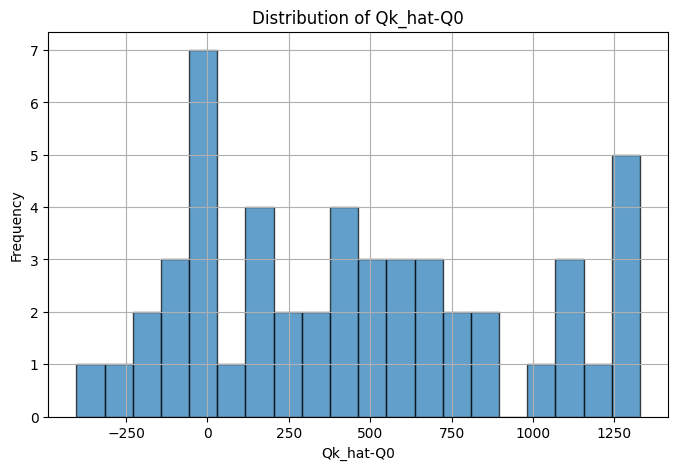

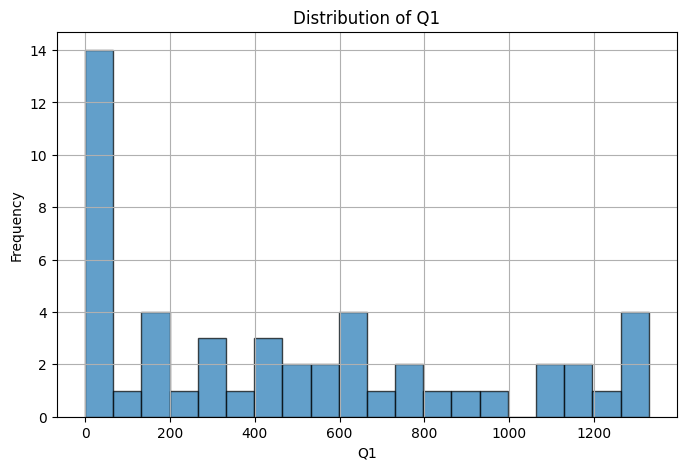

In [320]:
if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
    # Plotting the distribution of "Qk_hat-Q0"
    plt.figure(figsize=(8, 5))
    plt.hist(
        stimulation_results_df_2["Qk_hat-Q0"], bins=20, alpha=0.7, edgecolor="black"
    )
    plt.title("Distribution of Qk_hat-Q0")
    plt.xlabel("Qk_hat-Q0")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plotting the distribution of "Q1"
    plt.figure(figsize=(8, 5))
    plt.hist(stimulation_results_df_2["Q1"], bins=20, alpha=0.7, edgecolor="black")
    plt.title("Distribution of Q1")
    plt.xlabel("Q1")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [321]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/med_with_holding_cost_20_s2_100_202502040026.pkl


In [322]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
4     6    910397.529078
5     7    900550.384117
3     5    887323.058173

### S3 - Grid for Fixed F & Flexible Rk


In [323]:
results_df_3, stimulation_results_df_3 = None, None
# results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
#     assigned_Fs=ASSIGNED_FS,
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df_train=Qk_hat_df_train,
#     training_df=training_df,
# )

# results_df_3 = grid_fixed_F_flexible_R(
#     assigned_Fs=ASSIGNED_FS,
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df_train=Qk_hat_df_train,
#     training_df=training_df,
# )


# results_df_3

In [324]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

In [325]:
stimulation_results_df_3

In [326]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

results_df_3 is None


### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [327]:
results_df_5, stimulation_results_df_5 = None, None
# results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
# results_df_5

In [328]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

In [329]:
stimulation_results_df_5

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [330]:
results_df_6, stimulation_results_df_6 = None, None
# results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
results_df_6

In [331]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

In [332]:
stimulation_results_df_6

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [333]:
results_df_7, stimulation_results_df_7 = None, None
# results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
# results_df_7

In [334]:
if results_df_7 is not None:
    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [335]:
stimulation_results_df_7

#### S4 - Beta with softmax


In [169]:
results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_4

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 5000
Set parameter IntFeasTol to value 1e-09
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1100 rows, 2795 columns and 6149 nonzeros
Model fingerprint: 0x2a69f251
Model has 50 quadratic constraints
Model has 1250 general constraints
Variable types: 2395 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [2e-02, 3e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]



/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/4155387638.py:173: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


User MIP start did not produce a new incumbent solution

Presolve added 2668 rows and 10168 columns
Presolve time: 0.07s
Presolved: 5668 rows, 13413 columns, 43342 nonzeros
Presolved model has 450 SOS constraint(s)
Presolved model has 450 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 12479 continuous, 934 integer (934 binary)

Root relaxation: objective 4.785097e+07, 1480 iterations, 0.01 seconds (0.02 work units)
Another try with MIP start

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    4.353424e+07 4.7851e+07  9.92%     -    1s
     0     0 4.7851e+07    0  121 4.3534e+07 4.7851e+07  9.92%     -    1s
     0     0 4.7743e+07    0  122 4.3534e+07 4.7743e+07  9.67%     -    1s
     0     0 4.7742e+07    0  112 4.3534e+07 4.7742e+07  9.66%     -    1s
     0     0 4.7740e+07    0  115 4.3534e+07 4.7740e+07  9.66%     -    1s
H    0  

In [170]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

Model parameters saved as models/med_with_holding_cost_20_s4_50_202502040024.pkl


### Analysis


#### Baseline


In [171]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 662366.7465293044


#### S1


In [172]:
# 策略一
results_df_1

R(T)    F                                                 Q0  \
22     4  0.5  [1016.1326102272089, 1016.1326102272089, 1016....   
13     3  0.5  [1016.1326102272089, 1016.1326102272089, 1016....   
12     3  0.4  [812.9060881817672, 812.9060881817672, 812.906...   
23     4  0.6  [1219.3591322726509, 1219.3591322726509, 1219....   
14     3  0.6  [1219.3591322726509, 1219.3591322726509, 1219....   
..   ...  ...                                                ...   
65     9  0.3  [609.6795661363254, 609.6795661363254, 609.679...   
45     7  0.1  [203.2265220454418, 203.2265220454418, 203.226...   
54     8  0.1  [203.2265220454418, 203.2265220454418, 203.226...   
64     9  0.2  [406.4530440908836, 406.4530440908836, 406.453...   
63     9  0.1  [203.2265220454418, 203.2265220454418, 203.226...   

                                                   Q1  average_profits  \
22  [1239.4456767905015, 1726.5912710861592, 16.26...     9.534339e+05   
13  [1246.3208174049325, 1627.184776235037, 68.290...     9.528301e+05   
12  [1449.5473394503742, 1830.4112982804786, 271.5...     9.519366e+05   
23  [1036.2191547450595, 1523.3647490407172, 0, 66...     9.504369e+05   
14  [1043.0942953594906, 1423.958254189595, 0, 46....     9.448883e+05   
..                                                ...              ...   
65  [1520.8875116290005, 2062.426560562772, 311.12...    -4.968135e+05   
45  [2054.0675665761196, 2539.387358670023, 816.68...    -5.343514e+05   
54  [1970.1565382281115, 2487.4852783214906, 735.6...    -7.946770e+05   
64  [1724.1140336744422, 2265.6530826082135, 514.3...    -8.016533e+05   
63  [1927.340555719884, 2468.8796046536554, 717.57...    -1.106493e+06   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
22       39.332957      46.731456              996466.131544    662366.746529   
13       38.716772      49.171495              996774.224035    662366.746529   
12       42.022119      44.347781              995121.550540    662366.746529   
23       34.295722      62.800076              998984.749356    662366.746529   
14       38.716772      65.055000              996774.224035    662366.746529   
..             ...            ...                        ...              ...   
65     1008.630740    1008.630740              511817.240360    662366.746529   
45     1033.656015    1033.656015              499304.602692    662366.746529   
54     1207.206393    1207.206393              412529.413516    662366.746529   
64     1211.857262    1211.857262              410203.979337    662366.746529   
63     1415.083784    1415.083784              308590.718314    662366.746529   

    profit_diff_percent  
22            43.943507  
13            43.852344  
12            43.717450  
23            43.491028  
14            42.653348  
..                  ...  
65          -175.005803  
45          -180.673043  
54          -219.975374  
64          -221.028612  
63          -267.051421  

[72 rows x 10 columns]

In [173]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：540204.142614103
策略1最佳策略在：R=4, F=0.5
策略1最佳策略之下最大利潤為：953433.9249822205


#### S2


In [174]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2平均利潤為：947583.2907523972
策略2最佳策略在：R=8, F為彈性
策略2最佳策略之下最大利潤為：982943.3691135364


#### S3


In [175]:
# 策略三
results_df_3

In [176]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = stimulation_results_df_3.loc[
        stimulation_results_df_3["profits"].idxmax()
    ]
    max_profit_for_s3 = max_profit_row["profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

Model didn't find optimized result.


#### S4


In [177]:
results_df_4

average_profits  average_losses  average_lefts  average_operation_profits  \
0     1.000250e+06        5.808486     380.157873               1.013228e+06   

                                        alpha_values  \
0  [-0.3727604273293729, -0.5321576450303651, 1.9...   

                                         beta_values  \
0  [[0.0, 0.0, 0.0, 0.0, -1000000.0], [0.0, 0.0, ...   

                                          tau_values  
0  [[-1000000.0, -1000000.0, -1000000.0, -1000000...

In [178]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    # print(f"策略4最佳策略在：\nR為彈性, F={max_profit_row['F'][0]}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

策略4最佳策略之下最大利潤(Avg profit)為：1000249.7971575056


#### S5


In [179]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = stimulation_results_df_5.loc[
        stimulation_results_df_5["profits"].idxmax()
    ]
    max_profit_for_s5 = max_profit_row["profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

Model didn't find optimized result.


#### S6


In [180]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = stimulation_results_df_6.loc[
        stimulation_results_df_6["profits"].idxmax()
    ]
    max_profit_for_s6 = max_profit_row["profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

Model didn't find optimized result.


#### S7


In [181]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = stimulation_results_df_7.loc[
        stimulation_results_df_7["profits"].idxmax()
    ]
    max_profit_for_s7 = max_profit_row["profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


#### S8

In [182]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = stimulation_results_df_8.loc[
        stimulation_results_df_8["profits"].idxmax()
    ]
    max_profit_for_s8 = max_profit_row["profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

Model didn't find optimized result.


#### 比較&分析


##### 不同策略 Scatter

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_20_50_202502040024.png


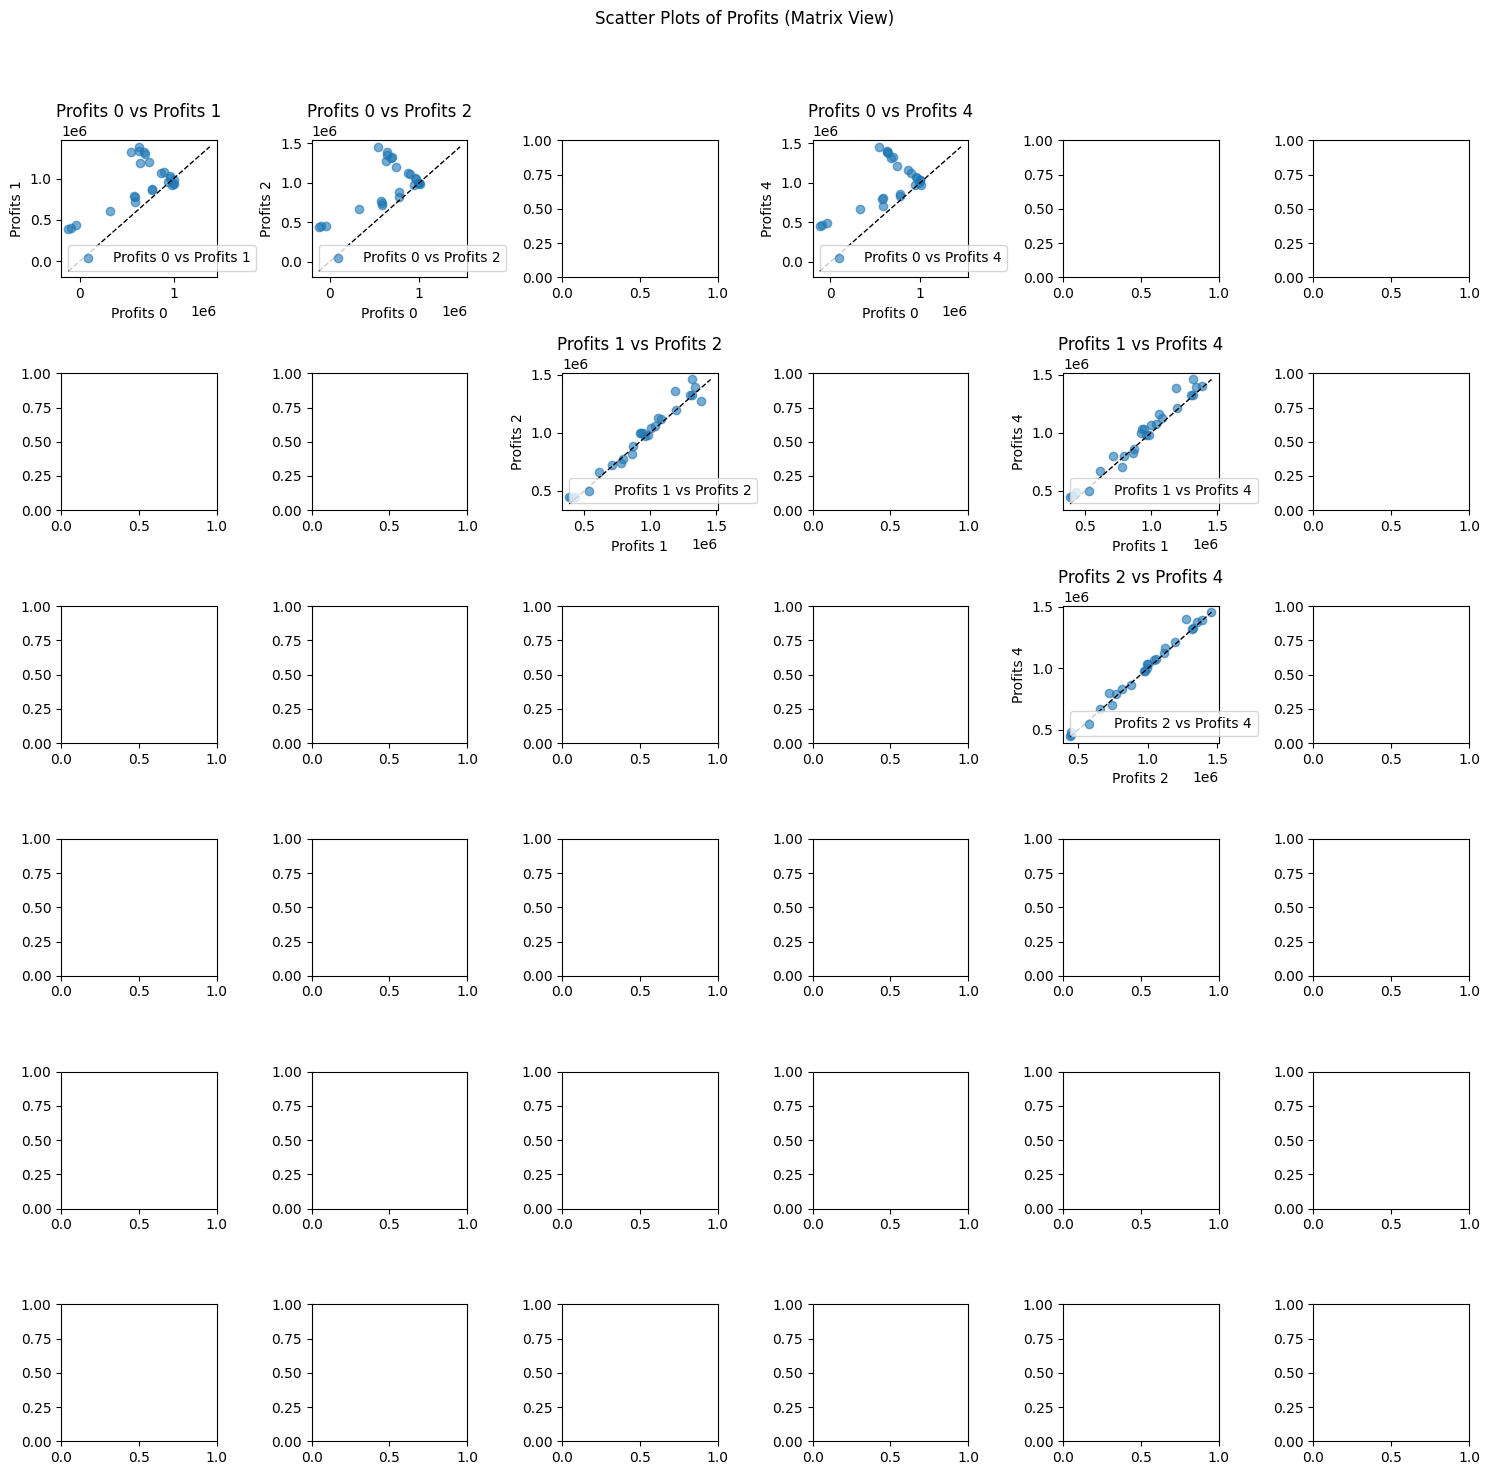

In [ ]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_20_50_S1_202502040024.png


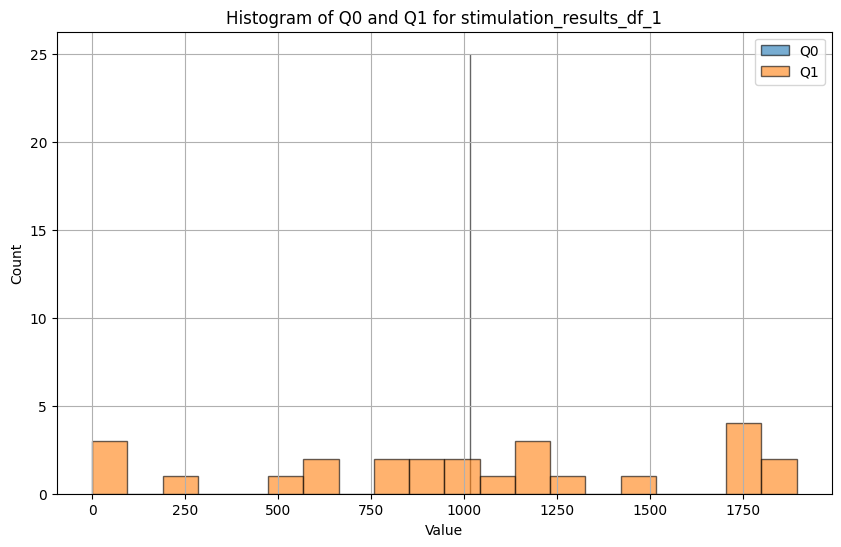

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_20_50_S2_202502040024.png


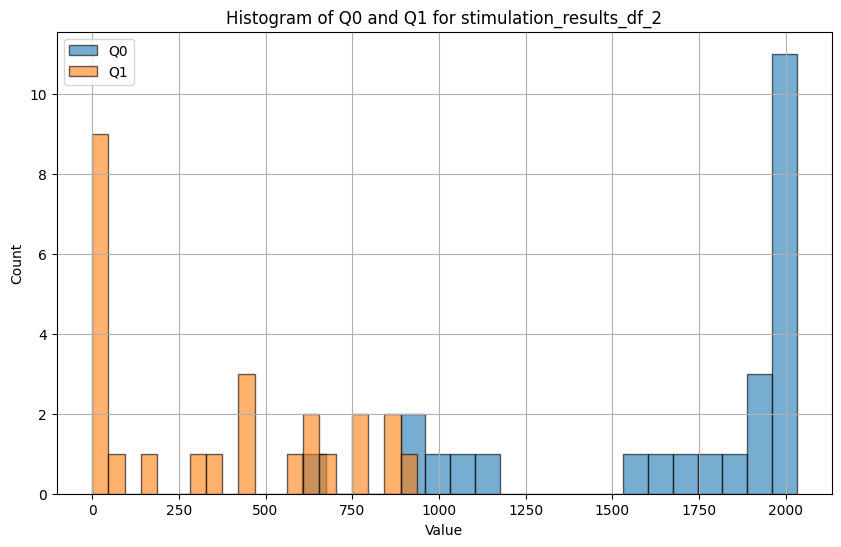

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_20_50_S4_202502040024.png


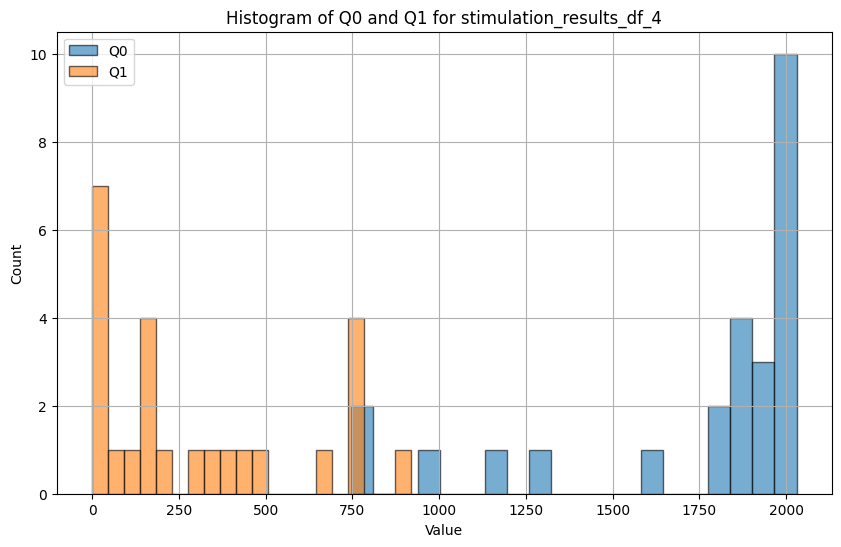

In [ ]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_50_S1_202502040024.png


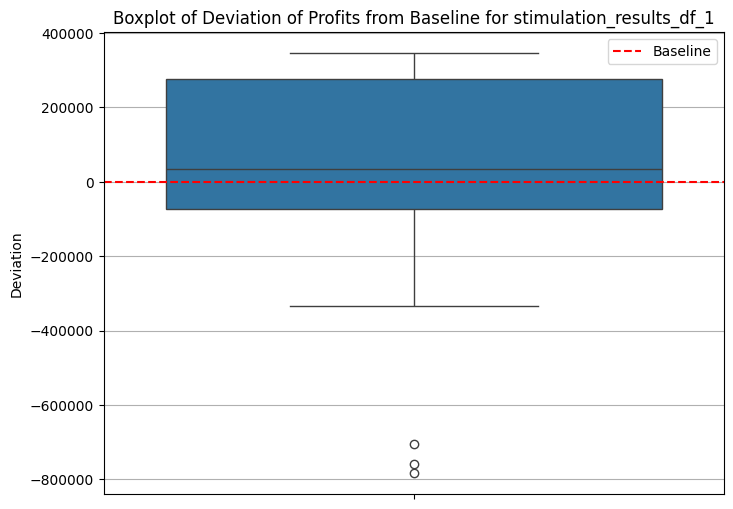

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_50_S2_202502040024.png


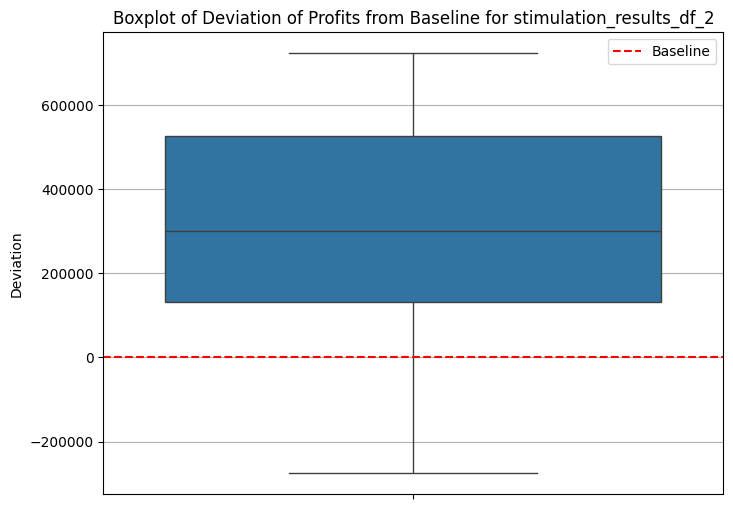

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_50_S3_202502040024.png


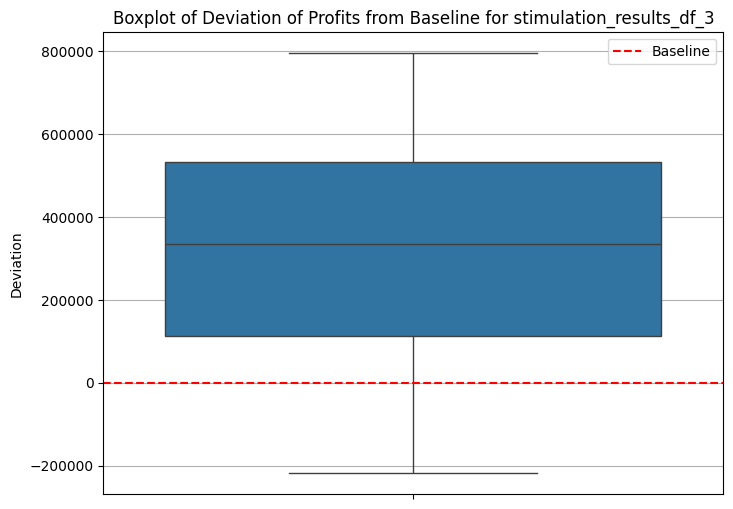

Skipping stimulation_results_df_4: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_50_S5_202502040024.png


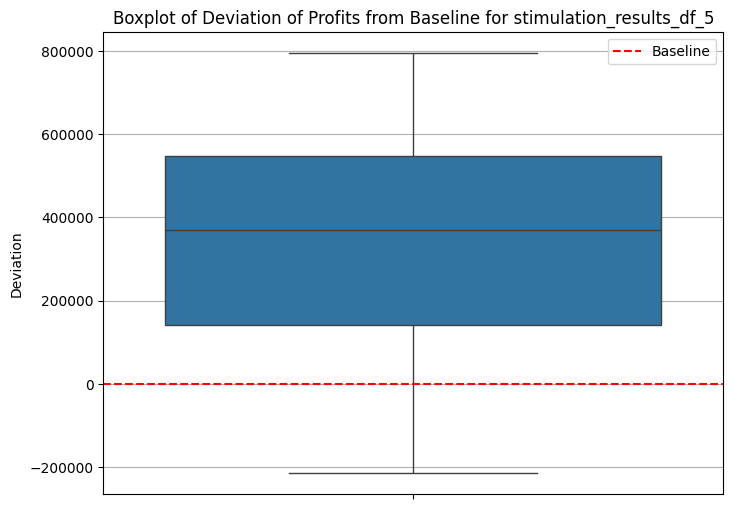

Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.
Skipping stimulation_results_df_9: Missing 'profits' column.


In [ ]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


Baseline is: 662366.7465293044
S1's profit: 953433.9249822205
S2's profit: 982943.3691135364
S3's profit: -1
S4's profit: 1000249.7971575056
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: -1
Plot saved as plots/plot_relative_profit_deviation_train_med_with_holding_cost_20_50_202502040024.png


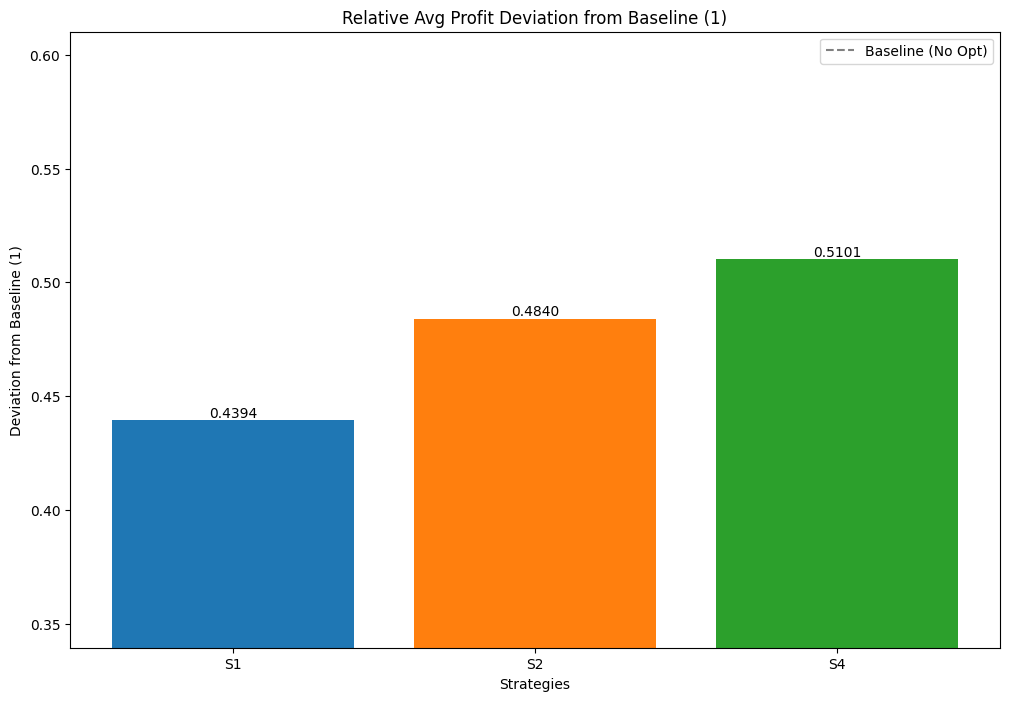

In [ ]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

#### Preparation


In [187]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [188]:
status = "test"

In [189]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 2032.2652204544179
std of sum: 604.4392725253209
50.0 percentile of sum: 2032.2652204544179
Q_star: 2032.2652204544179


In [ ]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (25, 8)


Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0  2186.316341  2196.291419  2193.790744  2194.145823  2401.744363   
1  1916.194219  2569.561354  2563.987892  2569.008100  2927.480342   
2  1411.992644  1609.326178  1608.120492  1607.017664  1961.992274   
3  2184.547159  1546.887771  1543.063857  1539.453511  1426.514366   
4  2481.318192  2406.276883  2407.682041  2406.975456  2194.690317   

     Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0  2401.744361  2344.926679  2275.914119  
1  2927.480325  2881.696304  2831.667029  
2  1961.992280  1966.111708  2013.535924  
3  1426.514378  1342.215357  1366.853903  
4  2194.690319  2042.832265  2066.117286

### Run all the strategies


Baseline

In [191]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/25 with initial inventory Q_star=2032.2652204544179
--------------------------------------------------
Day 1
Demand      : 324.5952831217071
Sales       : 324.5952831217071
Loss        : 0
Left        : 1707.6699373327108
Inventory   : 1707.6699373327108
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 215.04338252190357
Sales       : 215.04338252190357
Loss        : 0
Left        : 1492.6265548108072
Inventory   : 1492.6265548108072
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 209.38813655577124
Sales       : 209.38813655577124
Loss        : 0
Left        : 1283.2384182550359
Inventory   : 1283.2384182550359
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 215.04338495883445
Sales       : 215.04338495883445
Loss        : 0
Left        : 1068.1950332

In [192]:
test_stimulation_df_baseline.head()

losses       lefts  operation_profits        profits
0  243.648898    0.000000       1.016133e+06  894308.161097
1  799.401809    0.000000       1.016133e+06  616431.705723
2    0.000000   18.729296       1.006768e+06  997403.314037
3    0.000000  665.411317       6.834270e+05  350721.293077
4   33.852066    0.000000       1.016133e+06  999206.577461

S1

In [193]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.5, R: 4
Q_star 為 2032.2652204544179
期初庫存 Q0: 1016.1326102272089
重新估計量 Qk_hat: 2193.79074378162
訂貨量 Q1 為 1177.6581335544113

第一階段：期初庫存 Q0: 1016.1326102272089，需求量為 749.0268021993819，Sold_0 為 749.0268021993819，Left_0 為 267.10580802782704，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 1444.7639415822382，需求量為 1526.887316515191，Sold_1 為 1444.7639415822382，Left_1 為 0.0，Lost_1 為 82.12337493295286

統計結果：Sold 為 2193.79074378162, Lost 為 82.12337493295286 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 41061.687466476425，Profit 為 1055833.6844243337
----------------------------------------
這是第 2 筆模擬資料

F: 0.5, R: 4
Q_star 為 2032.2652204544179
期初庫存 Q0: 1016.1326102272089
重新估計量 Qk_hat: 2563.987892334385
訂貨量 Q1 為 1547.855282107176

第一階段：期初庫存 Q0: 1016.1326102272089，需求量為 610.2132025604587，Sold_0 為 610.2132025604587，Left_0 為 405.9194076667502，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 1953.7746897739262，需求量為 2221.4538269020354，Sold_1 為 1953.7746897739262，Left_1 為 0.0，Lost_1 為 267.67913712810923

統計結果：Sold 為 25

R(T)    F                                                 Q0  \
0     4  0.5  [1016.1326102272089, 1016.1326102272089, 1016....   

                                                  Q1  average_profits  \
0  [1177.6581335544113, 1547.855282107176, 591.98...    805263.780463   

   average_losses  average_lefts  average_operation_profits  
0       88.373771     104.928407              901914.869567

S2

In [194]:
results_df_2

R(T)                                                  R  average_profits  \
6     8  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...    982943.369114   
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...    980385.306458   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...    974044.230440   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...    969967.304205   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...    968941.730265   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    965669.195320   
7     9  [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...    939234.025140   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    799481.165078   

   average_losses  average_lefts  average_operation_profits  \
6       18.288303      29.801877               1.006988e+06   
5       18.916260      33.662089               1.006674e+06   
4       21.022341      42.132078               1.005621e+06   
2       19.951170      52.428273               1.006157e+06   
3       28.155983      38.069794               1.002055e+06   
1       28.289525      44.347781               1.001988e+06   
7       51.265723      51.265723               9.904997e+05   
0      118.827053     195.648784               9.567191e+05   

                                        alpha_values  \
6  [-0.2246010769082243, -0.9110629667011725, 1.6...   
5  [-0.20074155025813809, -0.6008714130926128, 2....   
4  [-0.823317384069923, -0.22563492519141842, 2.5...   
2  [-0.26205313807358016, -0.7661805233887146, 2....   
3  [-0.17656942959500943, -0.18318495053242947, 1...   
1  [-0.7684059640076548, -1.231558026822095, 1.54...   
7  [-0.23182474859322577, 0.1511648315430313, 1.5...   
0  [1.4646518210570656, -0.32873871488140527, 5.8...   

                                              F_vars  \
6  [0.7675633926852578, 0.9820137900379085, 0.461...   
5  [0.9571950961320181, 0.9996622217112476, 0.501...   
4  [0.965594061808614, 0.9996646500504096, 0.2478...   
2  [0.5000018105675118, 0.9996626698353821, 0.531...   
3  [0.5000016058835254, 0.5542715061094202, 0.504...   
1  [0.4881195038846245, 0.500002372345001, 0.2730...   
7  [0.8207294604363489, 0.999660839340929, 0.3490...   
0  [0.9996646511376369, 0.9996646509322541, 0.5, ...   

                                             Q0_vars  \
6  [1559.8923874482464, 1995.7124715006685, 938.8...   
5  [1945.2743030586237, 2031.578765385962, 1019.9...   
4  [1962.3432288909598, 2031.5837004151842, 503.6...   
2  [1016.1362897805925, 2031.5796760930548, 1079....   
3  [1016.1358738084458, 1126.4267045550632, 1024....   
1  [991.9882911701875, 1016.1374314614454, 554.84...   
7  [1667.939937847112, 2031.5759560428417, 709.26...   
0  [2031.5837026247186, 2031.5837022073263, 1016....   

                                             Q1_vars  
6  [613.490672825307, 694.999328866264, 0.0, 342....  
5  [312.01978556293784, 711.0351153295028, 0.0, 0...  
4  [294.95086343508956, 711.0301736613621, 516.21...  
2  [1239.441997237118, 711.1442052203133, 0.0, 0....  
3  [1239.7850525605531, 1616.3629155953176, 0.0, ...  
1  [1270.465136461954, 1627.1799550008004, 529.57...  
7  [462.62713991821374, 640.5301706562557, 211.54...  
0  [28.826645497445043, 0.0, 976.688648377868, 25...

In [195]:
alphas = results_df_2.iloc[0]["alpha_values"]
alphas

array([-0.22460108, -0.91106297,  1.63726974, -0.11440591,  2.94089959])

In [196]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_2

assigned_R: 6


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/1454959989.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0    846950.230347  22296.920248  22296.920248   

                                        alpha_values  R(T)  
0  [-0.2246010769082243, -0.9110629667011725, 1.6...     8

S3

In [197]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_3

S4

In [198]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_4

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/1892652838.py:80: RuntimeWarning: overflow encountered in exp
  exp_tau_vars[i] = np.exp(-tau_vars[i])
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/1892652838.py:84: RuntimeWarning: invalid value encountered in divide
  r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_90615/1892652838.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0    689305.795544  29597.541923  29597.541923   

                                        alpha_values  \
0  [-0.3727604273293729, -0.5321576450303651, 1.9...   

                                         beta_balues  
0  [[0.0, 0.0, 0.0, 0.0, -1000000.0], [0.0, 0.0, ...

S5

In [199]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_5

In [200]:
test_stimulation_results_df_5

S6

In [201]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_6

In [202]:
test_stimulation_results_df_6

S7

In [203]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_7

S8

In [204]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_med_with_holding_cost_20_50_202502040024.png


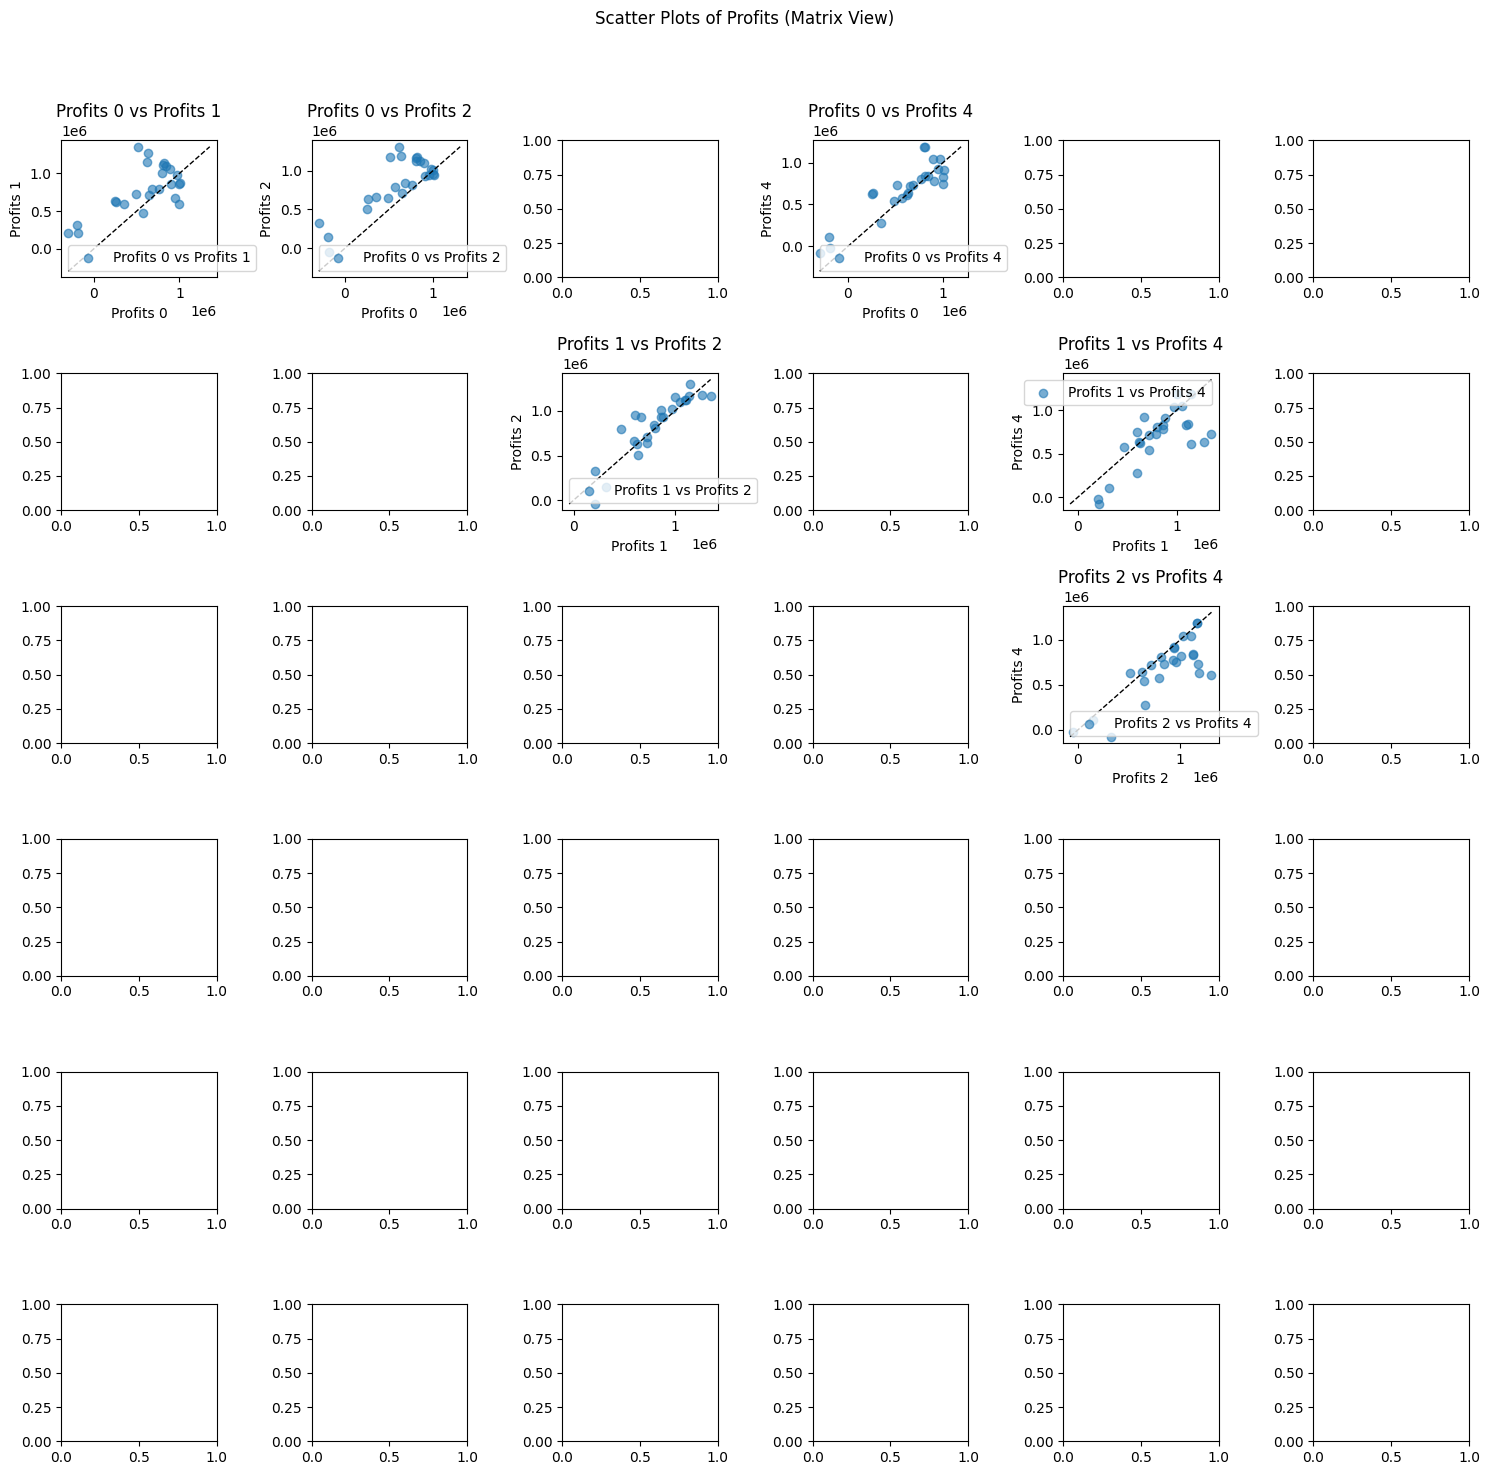

In [ ]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 604259.7809123832
S1's profit: 805263.7804629973
S2's profit: 846950.2303468493
S3's profit: -1
S4's profit: 689305.7955442645
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: -1
Plot saved as plots/plot_relative_profit_deviation_test_med_with_holding_cost_20_50_202502040024.png


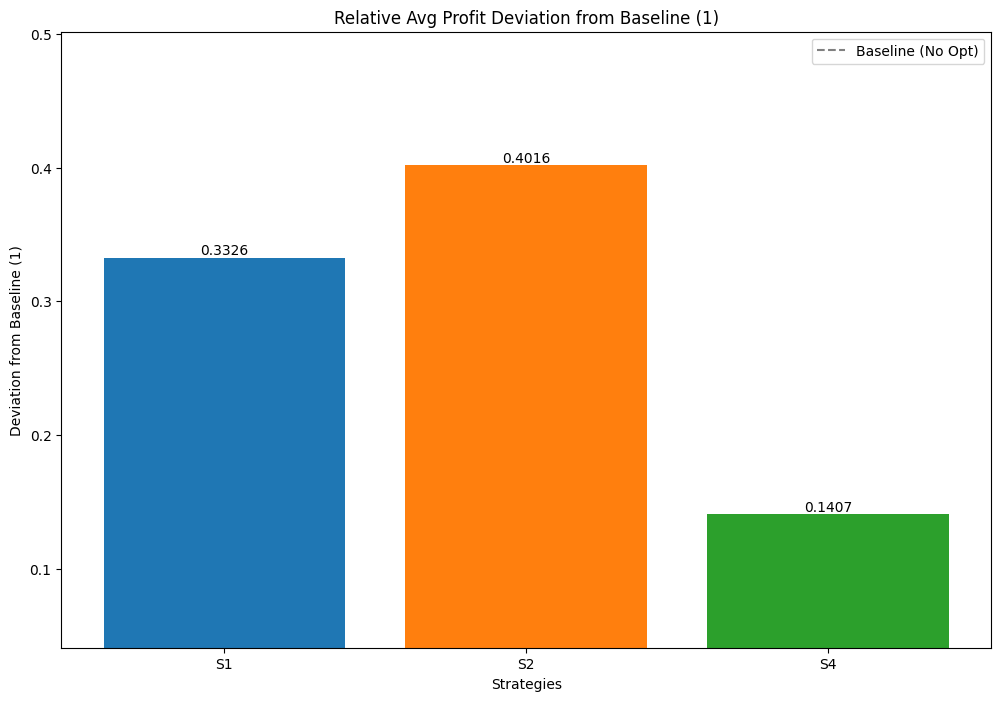

In [ ]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_20_50_S1_202502040024.png


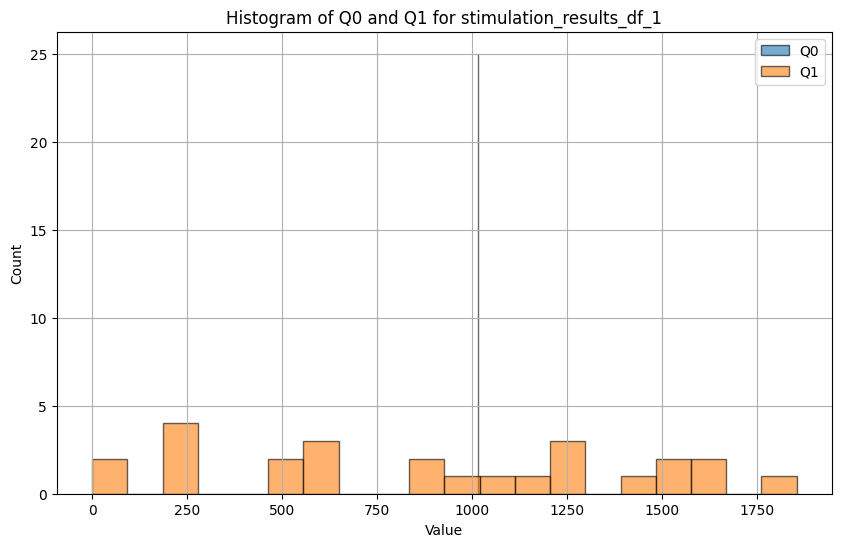

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_20_50_S2_202502040024.png


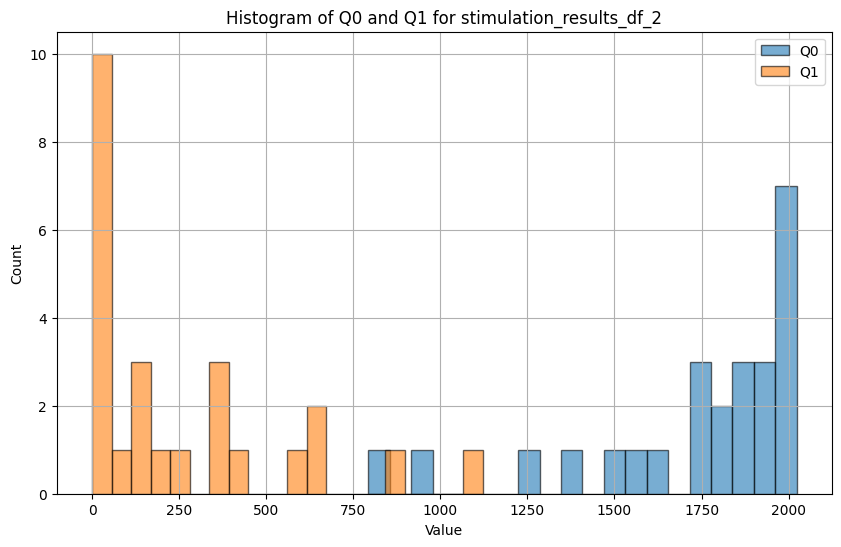

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_20_50_S4_202502040024.png


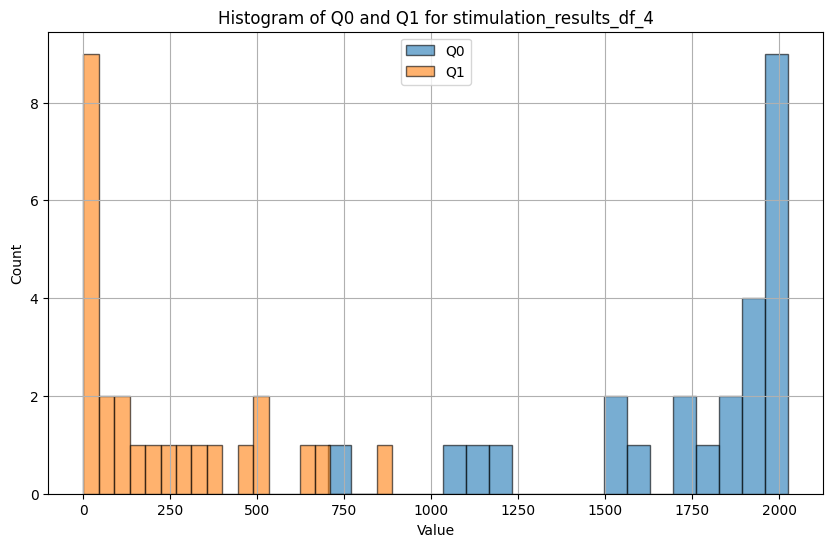

In [ ]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_50_S1_202502040024.png


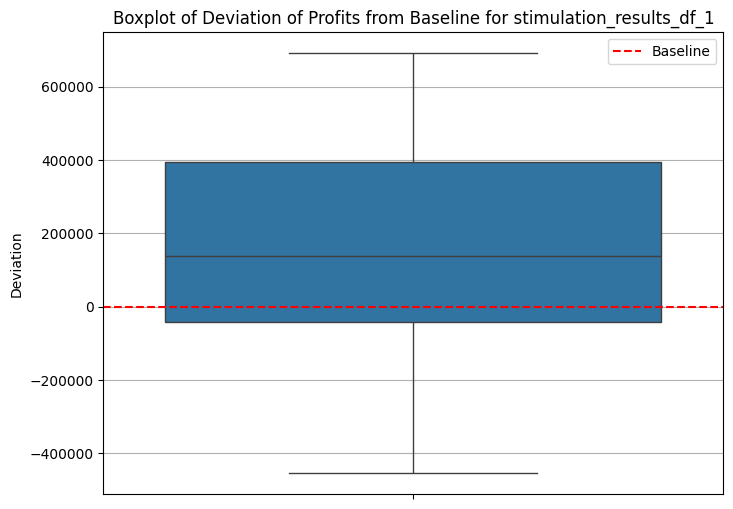

Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_50_S2_202502040024.png


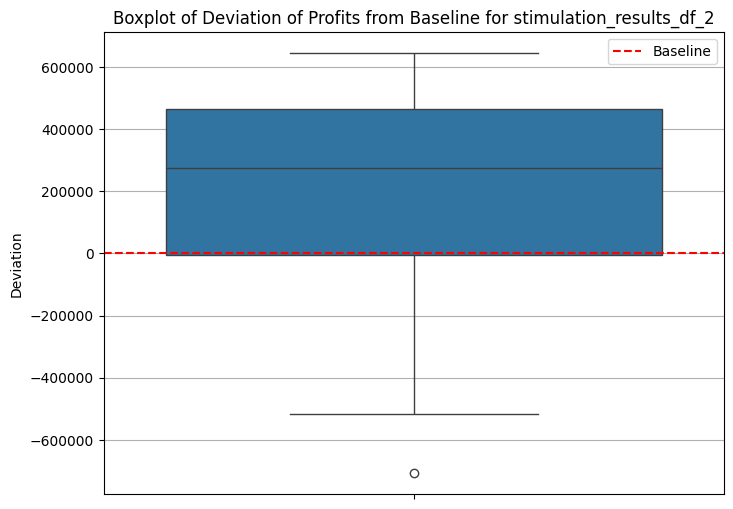

Skipping stimulation_results_df_3: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_50_S4_202502040024.png


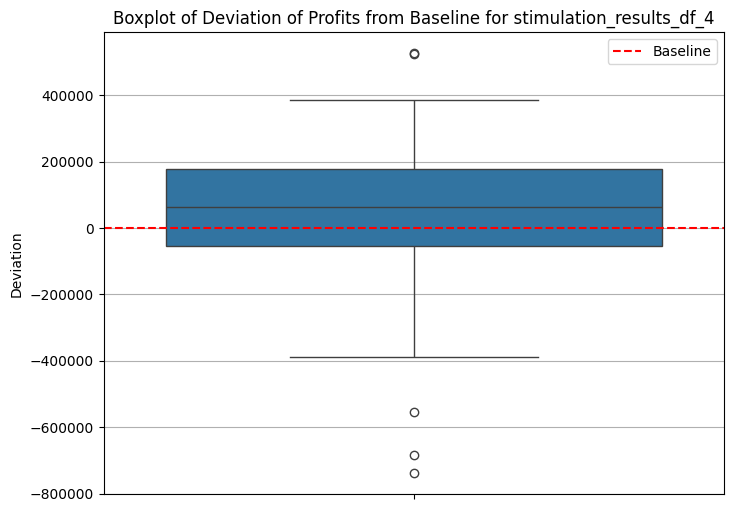

Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.


In [ ]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}", dfs[1:], baseline_avg_profits
)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_med_with_holding_cost_20_50_202502040024.png


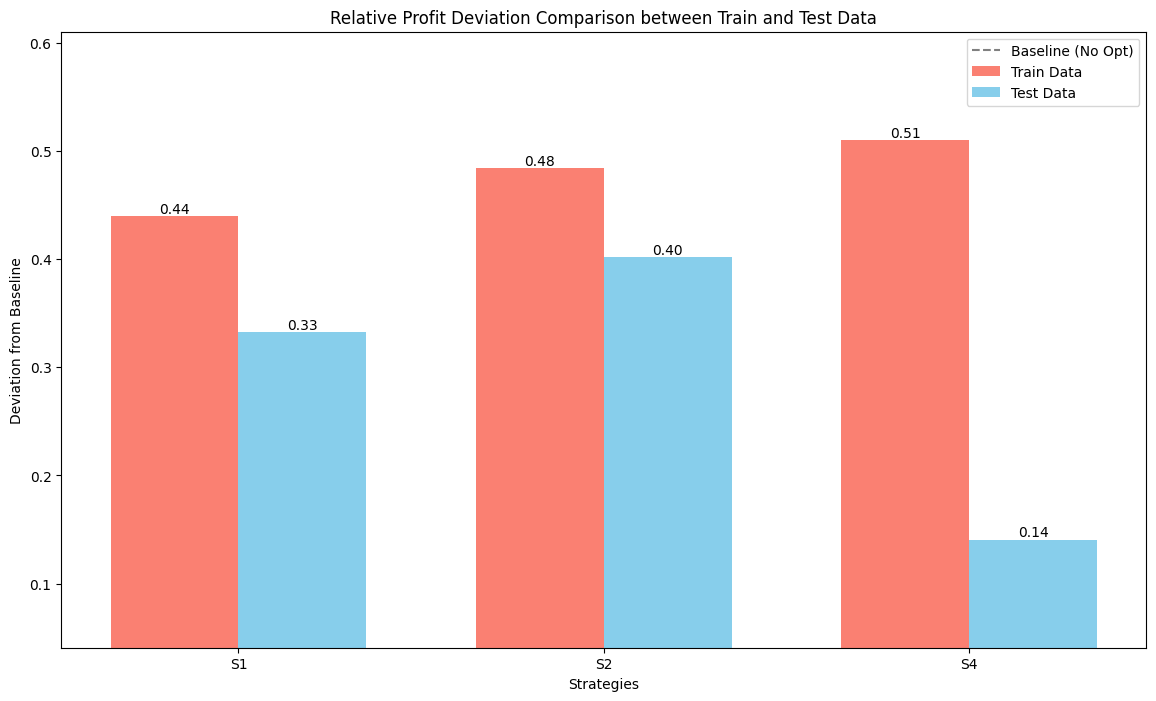

In [ ]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [210]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]